In [1]:
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import bernoulli
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import MDS
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from typing import Literal


numpyro.set_platform('cpu')
numpyro.set_host_device_count(16)

In [2]:
kaggle_submission = False
run_cv = True

# Logistic Regression with Tree-based Features Selection and Sampler

In this experiment,
I'll try perform uncorrelated features removal
and Bayesian logistic regression.

## Data

In [3]:
if kaggle_submission:
    train_path = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
    test_path = '/kaggle/input/icr-identify-age-related-conditions/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'

train_df = pd.read_csv(train_path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [4]:
test_df = pd.read_csv(test_path)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

### Data Preprocessing

In [5]:
imputer = SimpleImputer(strategy='median')
preprocessing = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [6]:
X_df = train_df.drop(columns=['Id', 'Class', 'EJ'])
y = train_df['Class']
ej = train_df['EJ'].astype('category')

X_df = pd.DataFrame(
    imputer.fit_transform(X_df),
    columns=X_df.columns,
    index=X_df.index)
y = y.values

### Interaction Terms

In [7]:
def create_interaction_terms_between(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    interactions = dict()

    for i, fst in enumerate(features):
        for snd in features[i+1:]:
            interactions[f'{fst}*{snd}'] = df[fst] * df[snd]

    return pd.DataFrame(interactions)

### Quadratic Terms

In [8]:
def create_quadratic_terms(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    return X_df[features].pow(2.).rename(columns={
        f: f'{f}^2' for f in features
    })

In [9]:
Xinteractions_df = create_interaction_terms_between(X_df, X_df.columns)
X2_df = create_quadratic_terms(X_df, X_df.columns)

Xtrain_df = pd.concat([X_df, Xinteractions_df, X2_df], axis=1)
# Xtrain_df['EJ'] = ej.cat.codes

### Correlations Removal

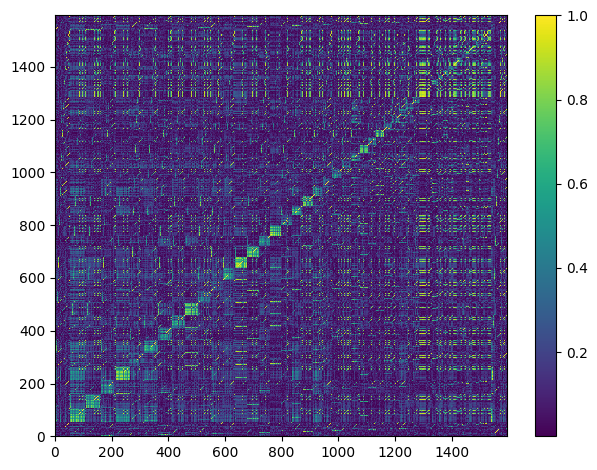

In [10]:
corr = Xtrain_df.corr('spearman')

fig, ax = plt.subplots()
cs = ax.pcolormesh(corr.abs())
fig.colorbar(cs, ax=ax)
fig.tight_layout()

/home/beekill/bin/mambaforge/envs/age/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

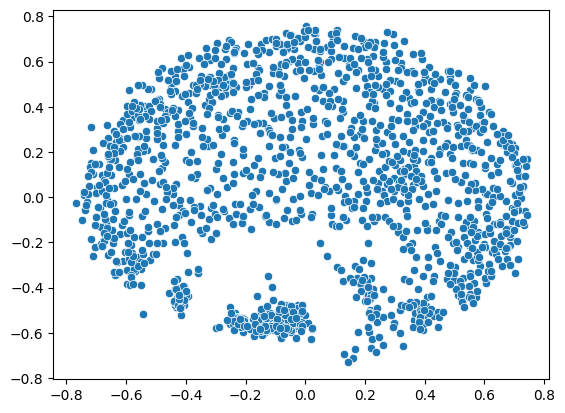

In [11]:
# Convert the correlation matrix into dissimilarity matrix,
# to be used with MDS.
distance = 1. - np.abs(corr)
mds = MDS(n_components=2, dissimilarity='precomputed')
embeddings = mds.fit_transform(distance)

# Show the results.
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1])

Clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

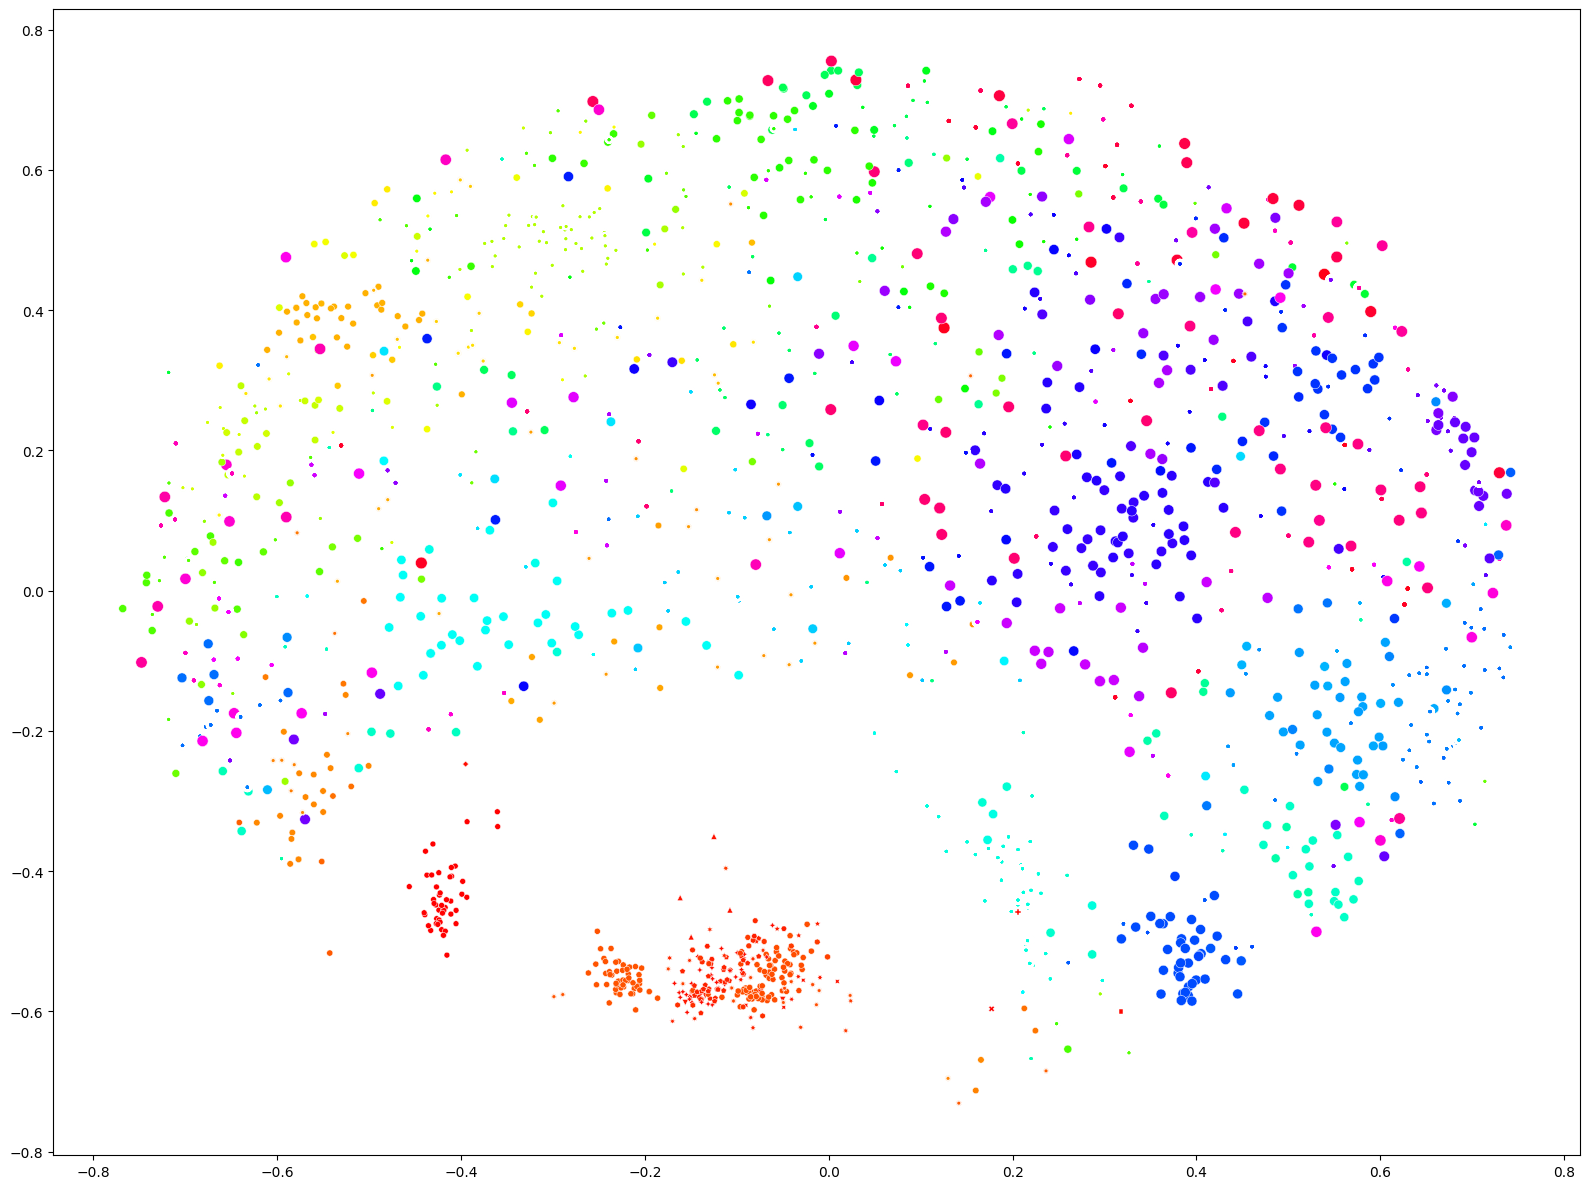

In [12]:
# Now, we can use clustering on the MDS's result
# to identify the clusters.
# clustering = DBSCAN(eps=0.1, min_samples=2, metric='precomputed')
# clusters = clustering.fit_predict(distance)
dist_linkage = hierarchy.ward(squareform(distance))
clusters = hierarchy.fcluster(dist_linkage, 0.3, criterion='distance')
unique_clusters = list(np.unique(clusters))
print(f'Clusters: {unique_clusters}')

# Plot the results.
fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(x=embeddings[:, 0],
                y=embeddings[:, 1],
                hue=clusters,
                style=clusters,
                size=clusters*100,
                palette='hsv',
                legend=False,
                ax=ax)
fig.tight_layout()

In [13]:
# Show the correlation in these clusters.
for cluster in unique_clusters:
    features_in_cluster = Xtrain_df.columns[clusters == cluster]
    X_in_cluster = Xtrain_df[features_in_cluster]
    corr_in_cluster = X_in_cluster.corr('spearman')
    corrs = 1 - squareform(1 - np.abs(corr_in_cluster))
    if len(features_in_cluster) > 1:
        print(f'{cluster=}, nb_features={len(features_in_cluster)}, '
              f'min={np.min(corrs)}, '
              f'max={np.max(corrs)}, mean={np.mean(corrs)}')
    else:
        print(f'{cluster=} has only 1 member.')

cluster=1, nb_features=47, min=0.6610663651465527, max=1.0, mean=0.8717003420133187
cluster=2 has only 1 member.
cluster=3 has only 1 member.
cluster=4 has only 1 member.
cluster=5 has only 1 member.
cluster=6, nb_features=33, min=0.853831339617906, max=1.0, mean=0.9147167073736575
cluster=7, nb_features=4, min=0.8476433715440829, max=0.9202469309244384, mean=0.8927511749537262
cluster=8, nb_features=4, min=0.8597206563102028, max=0.9462443710818355, mean=0.8991774649290855
cluster=9, nb_features=4, min=0.8537912907015649, max=0.9543980205027024, mean=0.902209830135333
cluster=10, nb_features=4, min=0.8893661261708603, max=0.9679051630992845, mean=0.927570034830481
cluster=11, nb_features=4, min=0.8697644756967174, max=0.958440050588756, mean=0.9072027141381702
cluster=12, nb_features=4, min=0.8761722038651139, max=0.9565649215041385, mean=0.9171461688673465
cluster=13, nb_features=38, min=0.8617061212929099, max=1.0, mean=0.925144595261086
cluster=14, nb_features=4, min=0.833351758802

Now, we can use these steps to extract the uncorrelated features.

In [14]:
def filter_in_uncorrelated_features(X_df: pd.DataFrame,
                                    correlation_threshold: float = 0.7):
    # Calculate Spearman's correlation, and then convert to
    # distances matrix.
    corr = X_df.corr('spearman')
    distances = 1. - corr.abs()

    # Perform clustering using Agglomerative Clustering.
    dist_linkage = hierarchy.ward(squareform(distances))
    clusters = hierarchy.fcluster(dist_linkage,
                                  1. - correlation_threshold,
                                  criterion='distance')

    # Choose a feature from each cluster.
    features = []
    for cluster in np.unique(clusters):
        features_in_cluster = X_df.columns[cluster == clusters]

        # TODO: Here, we use the first feature,
        # but it can be other choices.
        chosen_feature = features_in_cluster[0]
        features.append(chosen_feature)

    # Return a new dataframe with the chosen features.
    return X_df[features]

## Model
### Neural Network Classifier

In [15]:
class NNClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(512),

            nn.Linear(512, 64),
            # nn.Tanh(),
        )

        self.output = nn.Sequential(
            # nn.Dropout(),
            nn.LayerNorm(64),
            # nn.Dropout(),
            nn.Linear(64, 1),
        )

    def forward(self, x, *,
                mode: Literal['encoder', 'output', 'full'] = 'full',
                logit: bool = False):
        if mode == 'encoder':
            return self.encoder(x)
        elif mode == 'output':
            x = self.output(x)
            return x if logit else torch.sigmoid(x)
        elif mode == 'full':
            x = self.encoder(x)
            x = self.output(x)
            return x if logit else torch.sigmoid(x)

        raise ValueError(f'Unknown mode={mode}')


def create_training_and_evaluation_step(
        model: nn.Module,
        lr=1e-3,
        weight_decay=1e-5,
        regularization_weight=1e-2):

    loss_fn = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    # Init weights before training.
    def init_weights(m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear, nn.LazyLinear]:
            strategy_fn(m.weight)

    model.apply(lambda m: init_weights(m))

    def encoder_regularization_loss(x: torch.Tensor):
        """
        Calculate regularization loss of the encoder's output.

        x should have shape (nb_batches, nb_features)
        """
        # First, the output should be normally distributed.
        l1 = torch.mean(torch.sum(x**2, axis=1))

        # Second, features should not be correlated.
        cov = torch.t(x) @ x
        cov = cov - torch.diag(torch.diag(cov))
        l2 = torch.mean(torch.abs(cov))

        return l1 + l2

    def train_step(dataloader: DataLoader, *,
                   device: str, epoch: int, progress: bool = True,
                   train_noise: float = 0.0):
        model.train()

        train_loss = 0
        regularization_loss = 0

        num_batches = len(dataloader)
        bar = (tqdm(
            enumerate(dataloader), total=num_batches, desc=f'Epoch {epoch}')
            if progress
            else enumerate(dataloader))
        for i, (X, y) in bar:
            X, y = X.to(device), y.to(device)

            # Add noise to the training.
            X = X + train_noise * torch.rand_like(X)

            # Make prediction and calculate loss.
            encoder_output = model(X, mode='encoder')
            pred = model(encoder_output, mode='output', logit=True)

            # Losses.
            encoder_loss = encoder_regularization_loss(encoder_output)
            classification_loss = loss_fn(pred, y)

            loss = regularization_weight * encoder_loss + classification_loss
            regularization_loss += encoder_loss.item()
            train_loss += loss.item()

            # Back-propagation step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Show the MSE.
            if progress:
                bar.set_postfix_str(
                    f'Loss: {(train_loss / (i + 1)):.4f}'
                    f'- Encoder loss: {regularization_loss / (i + 1):.4f}')

        return train_loss / num_batches, regularization_loss / num_batches

    def evaluate_step(dataloader: DataLoader, device: str):
        num_batches = len(dataloader)
        model.eval()

        test_loss = 0
        regularization_loss = 0

        with torch.no_grad():
            for i, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                encoder_output = model(X, mode='encoder')
                pred = model(encoder_output, mode='output', logit=True)

                encoder_loss = encoder_regularization_loss(
                    encoder_output).item()
                regularization_loss += encoder_loss
                test_loss += (loss_fn(pred, y).item()
                              + regularization_weight * encoder_loss)

        test_loss /= num_batches
        return test_loss, regularization_loss / num_batches

    return train_step, evaluate_step


def train(model: nn.Module,
          *,
          train_ds: DataLoader,
          val_ds: DataLoader,
          epochs: int,
          train_noise: float = 0.0,
          early_stopping_patience: int = 100,
          device: str = 'cpu',
          lr: float = 1e-3,
          weight_decay: float = 1e-2,
          regularization_weight: float = 1.0):
    def save_checkpoint(model, path):
        torch.save(model.state_dict(), path)

    def load_checkpoint(model, path):
        model.load_state_dict(torch.load(path))
        return model

    model = model.to(device)

    train_step, val_step = create_training_and_evaluation_step(
        model,
        lr=lr,
        weight_decay=weight_decay,
        regularization_weight=regularization_weight)
    train_losses = []
    val_losses = []

    tmp_path = 'tmp_autoencoder.pth'

    patience = 0
    bar = tqdm(range(epochs), total=epochs, desc='Training')
    for epoch in bar:
        train_loss, train_regu_loss = train_step(
            train_ds, device=device, epoch=epoch, progress=False,
            train_noise=train_noise)
        train_losses.append(train_loss)

        val_loss, val_regu_loss = val_step(val_ds, device)
        val_losses.append(val_loss)

        bar.set_postfix_str(
            f'Train: {train_loss:.4f} - Val: {val_loss:.4f}'
            f'-Train Reg: {train_regu_loss:.4f} - Val Reg:{val_regu_loss:.4f}')

        patience += 1
        if val_loss <= np.min(val_losses):
            save_checkpoint(model, tmp_path)
            patience = 0
        else:
            if patience > early_stopping_patience:
                print(f'The validation does not improve for the last {patience} epochs. '
                      'Early stopping!')
                break

    # Best validation score and corresponding train score.
    best_val_idx = np.argmin(val_losses)
    print(
        f'Train: {train_losses[best_val_idx]:.4f} '
        f'- Val: {val_losses[best_val_idx]:.4f} at epoch {best_val_idx}.')

    # Restore the best model.
    print('Restore the best model.')
    return (load_checkpoint(model, tmp_path),
            dict(train_loss=train_losses,
                 val_loss=val_losses,
                 best_epoch=best_val_idx))

### Features Selection

In [16]:
def select_important_features(
        X, y, *, n_estimators: int = 50, important_thresholds: float = 0.5):
    model = ExtraTreesClassifier(n_estimators=n_estimators)
    model.fit(X, y)
    print(model.feature_importances_)
    selector = SelectFromModel(
        model,
        prefit=True,
        threshold=important_thresholds)
    x = selector.fit_transform(X, y)
    return pd.DataFrame(x, columns=selector.get_feature_names_out())

### Oversampling

In [17]:
def sampling(X, y):
    ros = SMOTENC(['ej'], sampling_strategy='all', random_state=0)
    columns = X.columns
    x, y = ros.fit_resample(X, y)
    return pd.DataFrame(x, columns=columns), y

### Cross Validation


-- Fold # 1/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2301 - Val: 0.2599 at epoch 280.
Restore the best model.


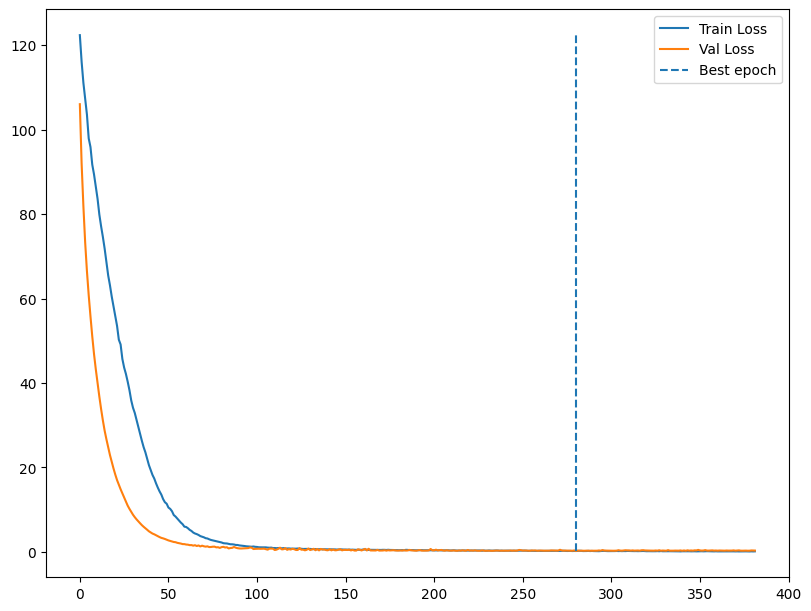

(20000, 555)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.0447 opt-log-loss=0.0453
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.2127 opt-log-loss=0.1747

-- Fold # 1/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2940 - Val: 0.2826 at epoch 227.
Restore the best model.


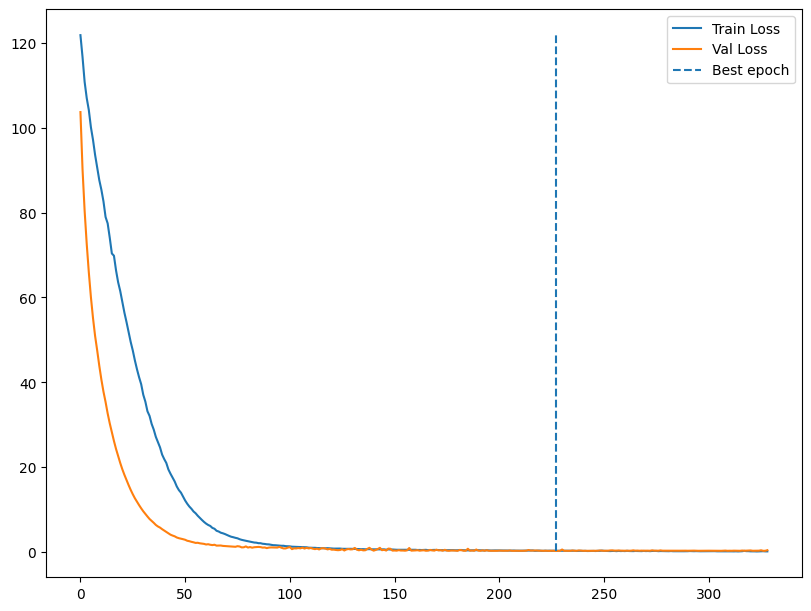

(20000, 555)
(20000,)
Train - f1=0.9171 recall=0.9691 precision=0.8704 log-loss=0.1075 opt-log-loss=0.1140
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.2986 opt-log-loss=0.2471

-- Fold # 1/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2965 - Val: 0.3008 at epoch 237.
Restore the best model.


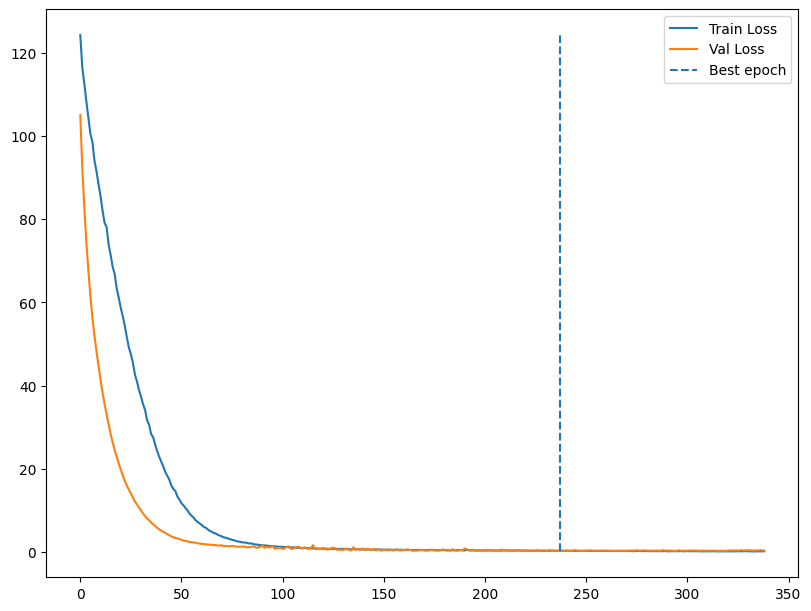

(20000, 555)
(20000,)
Train - f1=0.9326 recall=0.9278 precision=0.9375 log-loss=0.1268 opt-log-loss=0.0986
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.4006 opt-log-loss=0.2650

-- Fold # 1/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0810 - Val: 0.2507 at epoch 445.
Restore the best model.


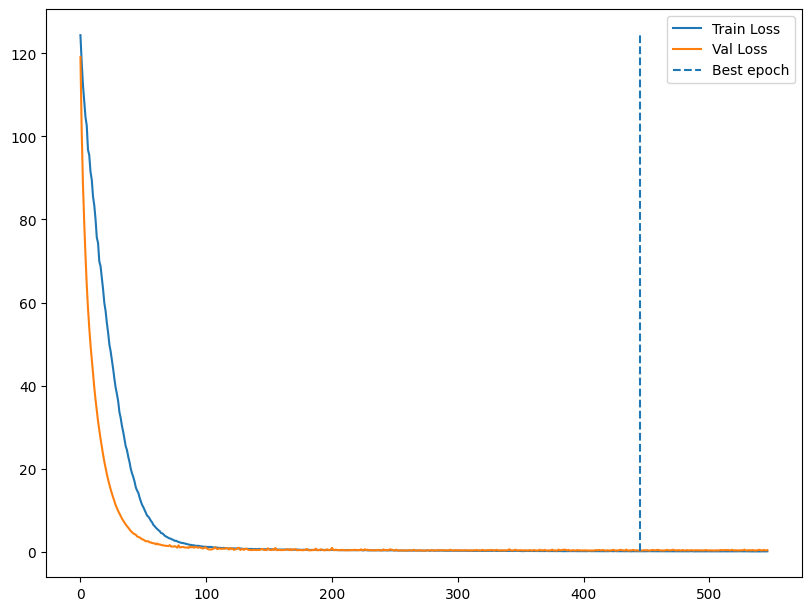

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0064 opt-log-loss=0.0049
(20000, 62)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.4047 opt-log-loss=0.2419

-- Fold # 1/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0929 - Val: 0.2403 at epoch 411.
Restore the best model.


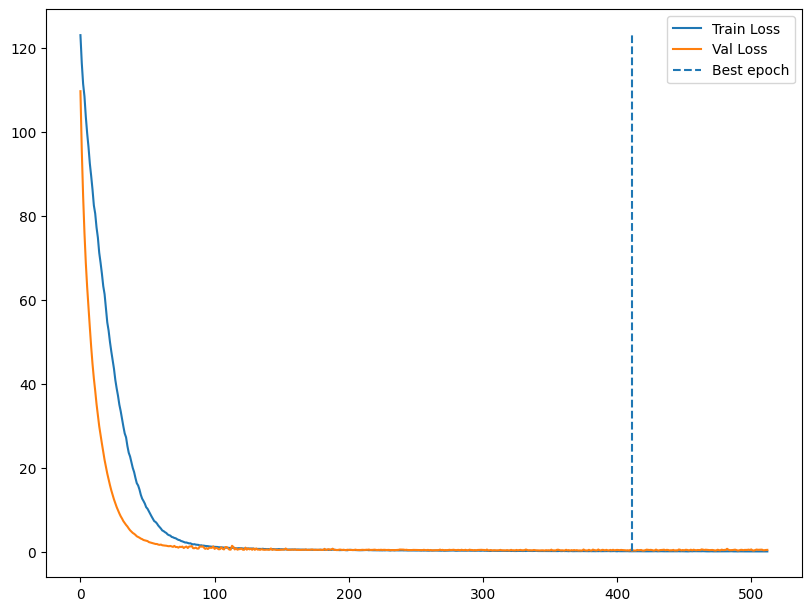

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0075 opt-log-loss=0.0066
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.3784 opt-log-loss=0.2170

-- Fold # 1/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3468 - Val: 0.2610 at epoch 209.
Restore the best model.


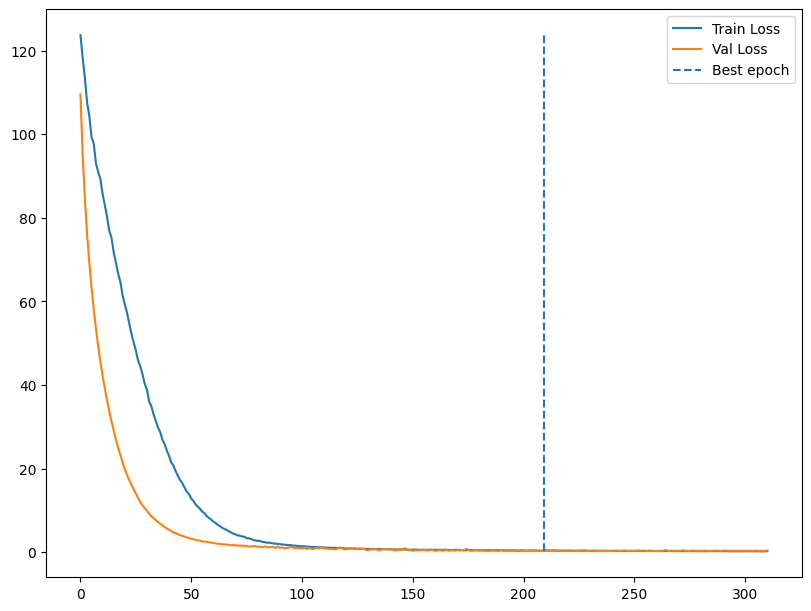

(20000, 555)
(20000,)
Train - f1=0.8932 recall=0.9485 precision=0.8440 log-loss=0.1464 opt-log-loss=0.1484
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.1981 opt-log-loss=0.1864

-- Fold # 1/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1955 - Val: 0.1861 at epoch 307.
Restore the best model.


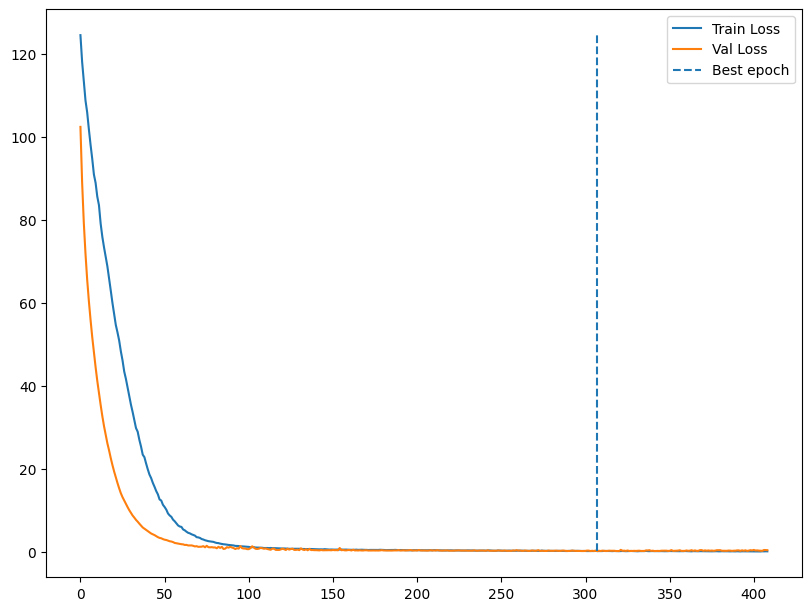

(20000, 555)
(20000,)
Train - f1=0.9846 recall=0.9897 precision=0.9796 log-loss=0.0364 opt-log-loss=0.0346
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.1648 opt-log-loss=0.1242

-- Fold # 1/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0871 - Val: 0.2157 at epoch 469.
Restore the best model.


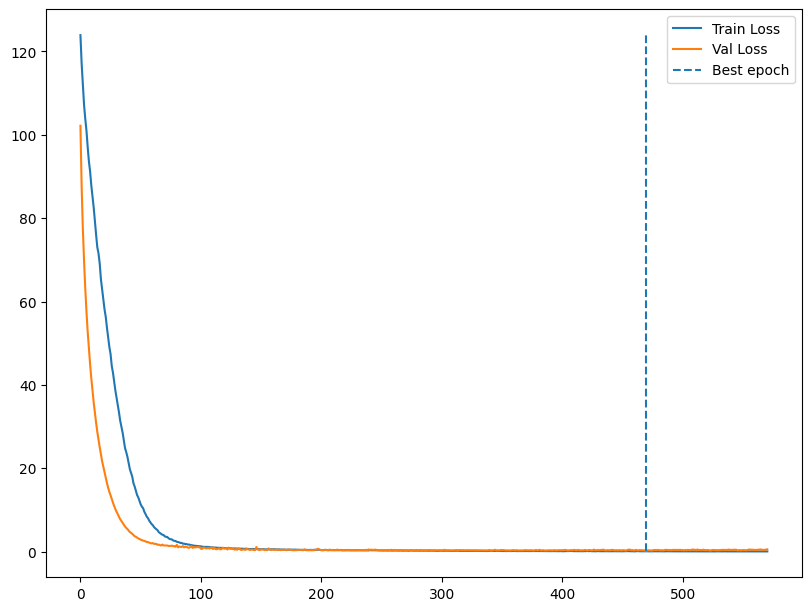

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0035 opt-log-loss=0.0058
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.1796 opt-log-loss=0.1582

-- Fold # 1/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1971 - Val: 0.2512 at epoch 310.
Restore the best model.


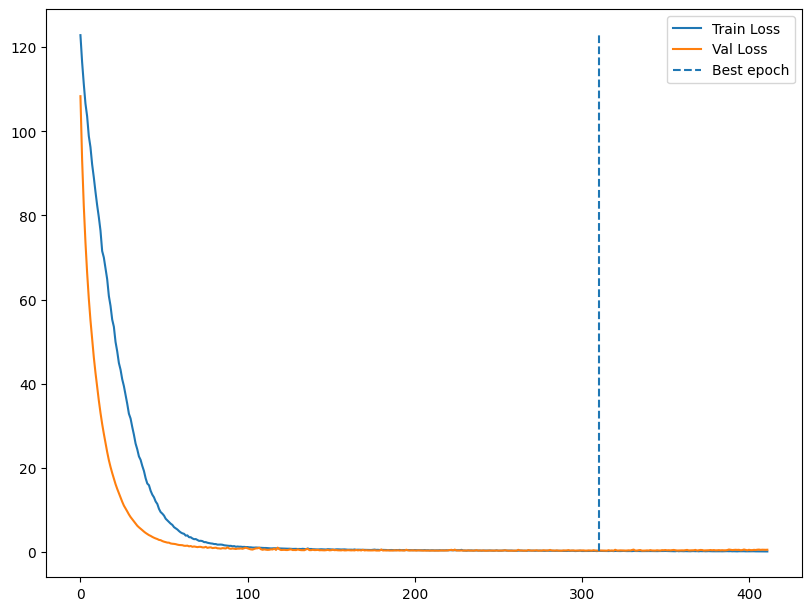

(20000, 555)
(20000,)
Train - f1=0.9746 recall=0.9897 precision=0.9600 log-loss=0.0435 opt-log-loss=0.0524
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2076 opt-log-loss=0.1810

-- Fold # 1/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1794 - Val: 0.2846 at epoch 333.
Restore the best model.


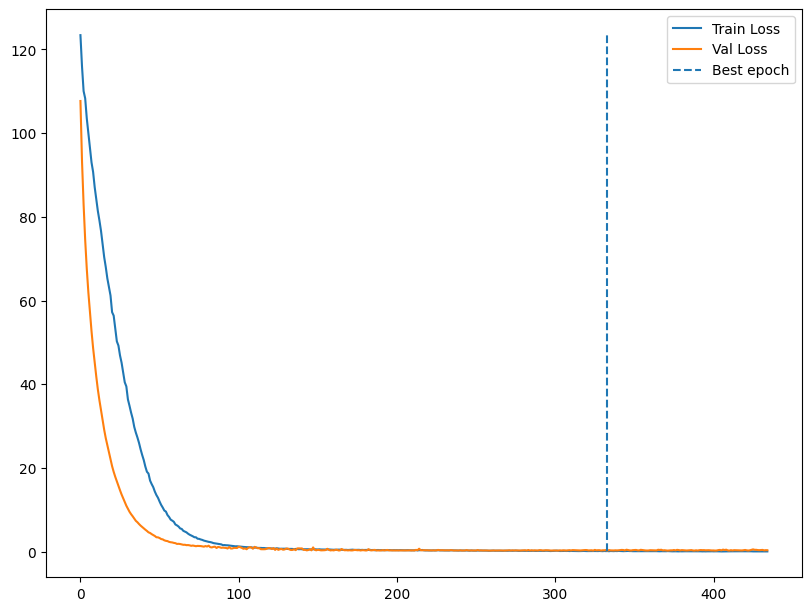

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0151 opt-log-loss=0.0229
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.3410 opt-log-loss=0.2325

-- Fold # 2/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3409 - Val: 0.2929 at epoch 227.
Restore the best model.


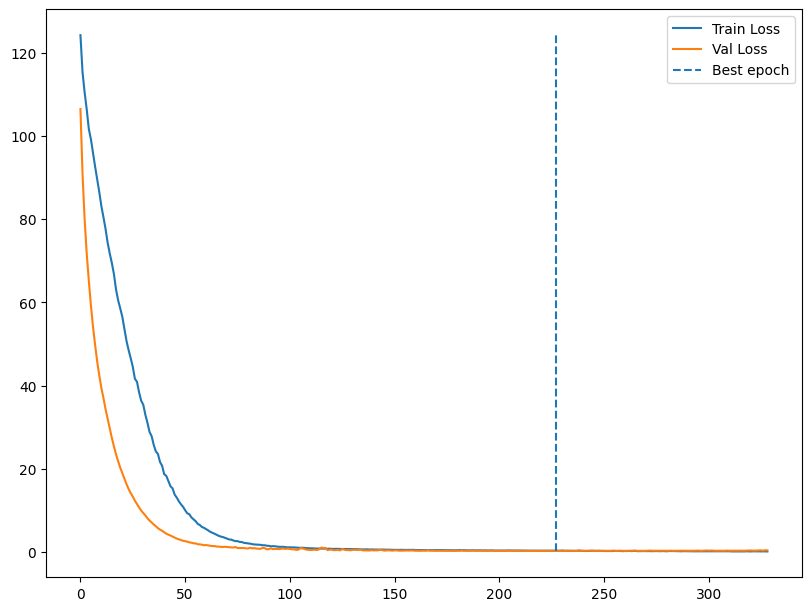

(20000, 555)
(20000,)
Train - f1=0.8716 recall=0.9794 precision=0.7851 log-loss=0.1002 opt-log-loss=0.1347
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3065 opt-log-loss=0.2638

-- Fold # 2/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3807 - Val: 0.2749 at epoch 209.
Restore the best model.


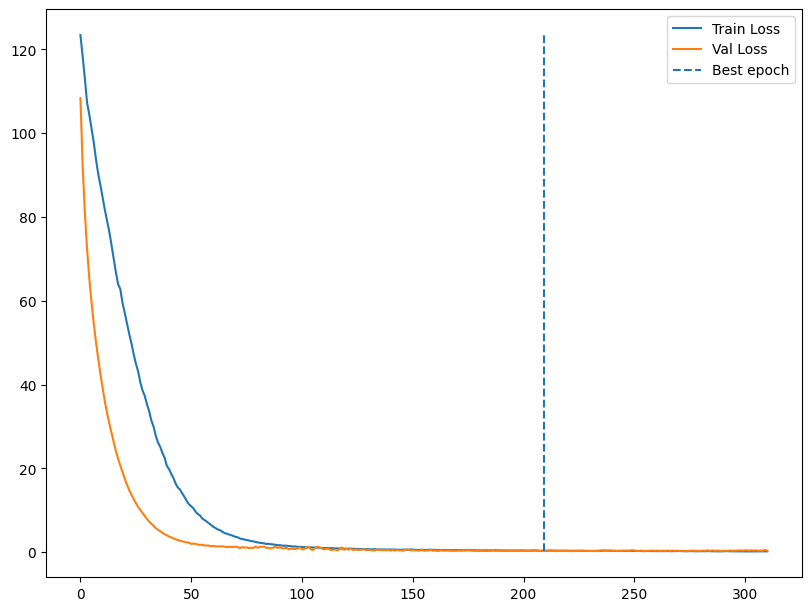

(20000, 555)
(20000,)
Train - f1=0.8785 recall=0.9691 precision=0.8034 log-loss=0.1141 opt-log-loss=0.1421
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2793 opt-log-loss=0.2166

-- Fold # 2/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4081 - Val: 0.3160 at epoch 223.
Restore the best model.


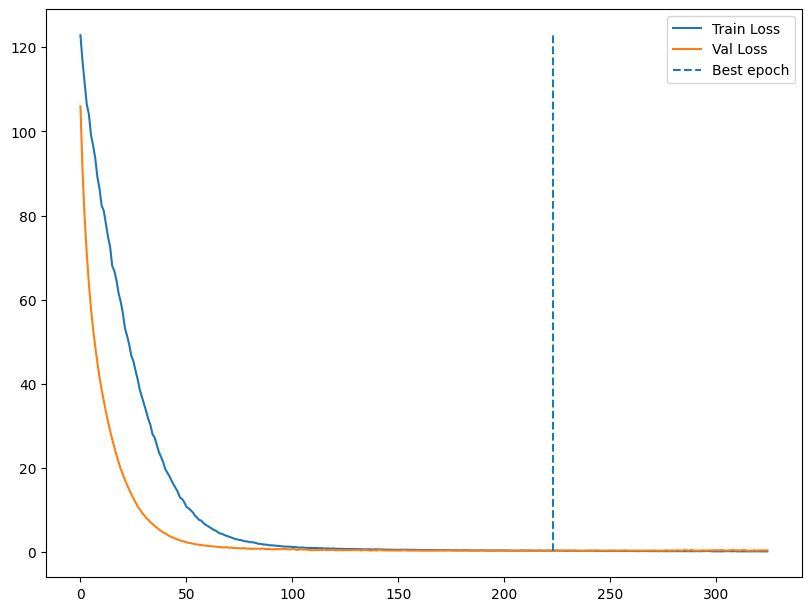

(20000, 555)
(20000,)
Train - f1=0.8995 recall=0.9691 precision=0.8393 log-loss=0.1201 opt-log-loss=0.1321
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3699 opt-log-loss=0.2905

-- Fold # 2/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3961 - Val: 0.2529 at epoch 210.
Restore the best model.


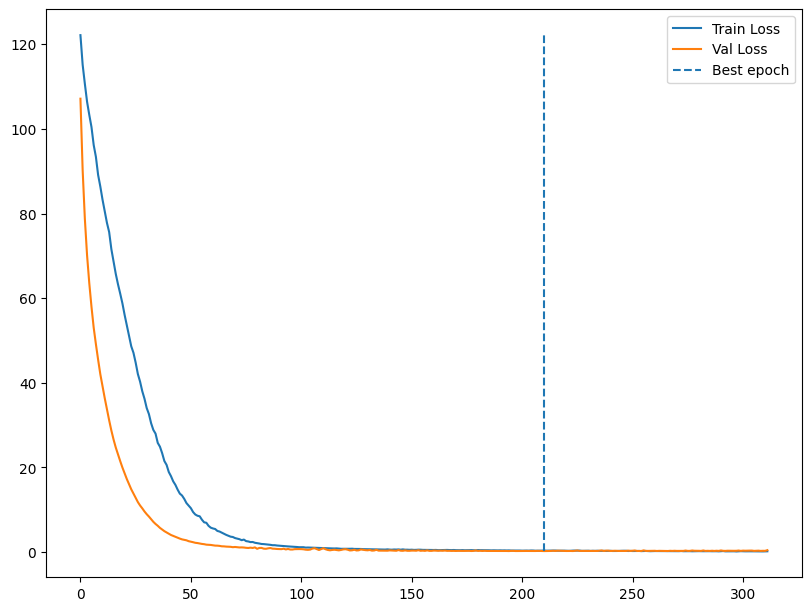

(20000, 555)
(20000,)
Train - f1=0.8598 recall=0.9485 precision=0.7863 log-loss=0.1316 opt-log-loss=0.1543
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2876 opt-log-loss=0.2175

-- Fold # 2/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4039 - Val: 0.2396 at epoch 198.
Restore the best model.


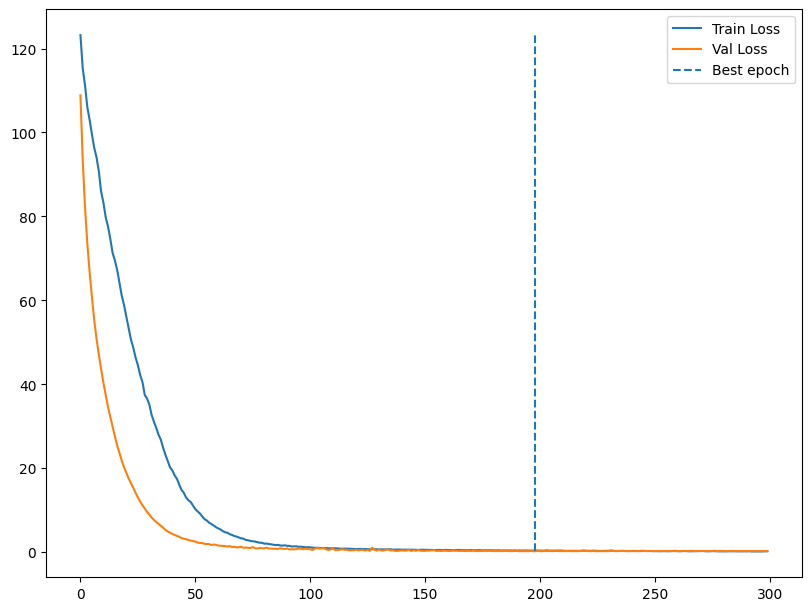

(20000, 555)
(20000,)
Train - f1=0.8455 recall=0.9588 precision=0.7561 log-loss=0.1437 opt-log-loss=0.1687
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2295 opt-log-loss=0.2018

-- Fold # 2/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3751 - Val: 0.2838 at epoch 202.
Restore the best model.


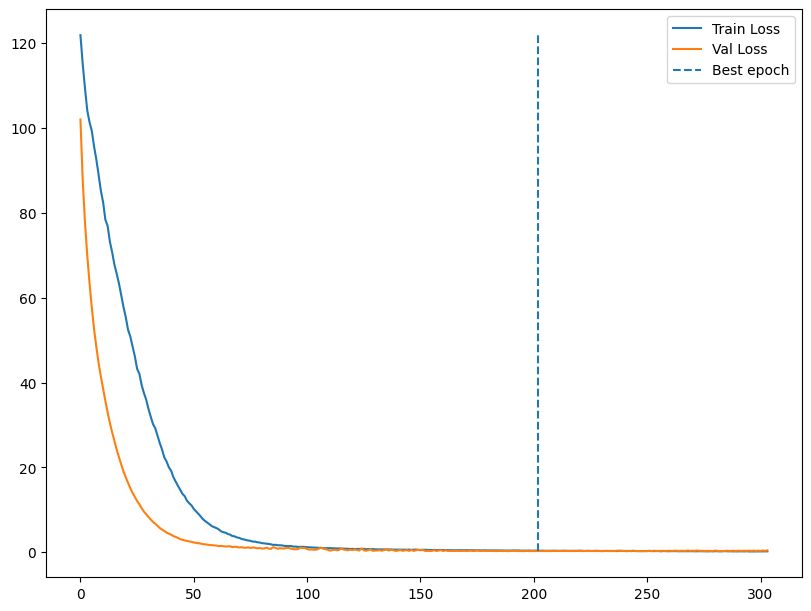

(20000, 555)
(20000,)
Train - f1=0.8348 recall=0.9897 precision=0.7218 log-loss=0.1425 opt-log-loss=0.1900
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3275 opt-log-loss=0.2672

-- Fold # 2/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3252 - Val: 0.2803 at epoch 219.
Restore the best model.


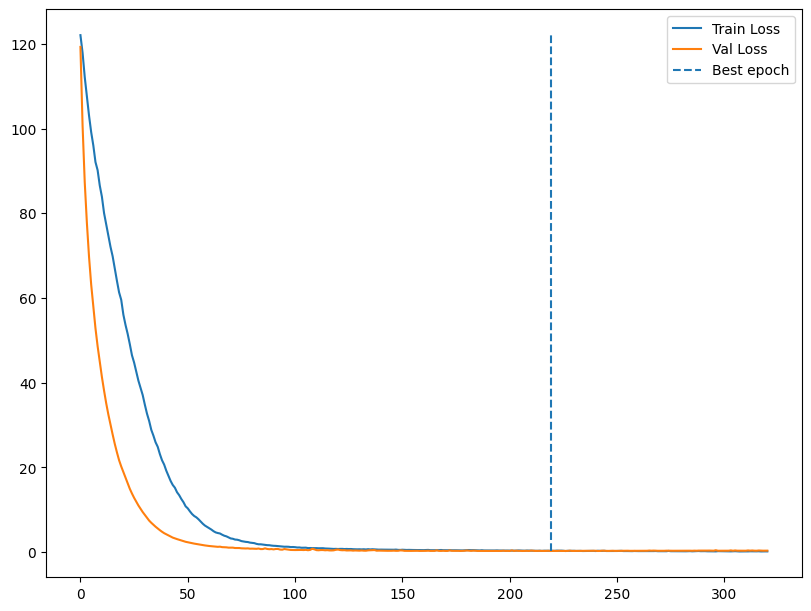

(20000, 555)
(20000,)
Train - f1=0.8756 recall=0.9794 precision=0.7917 log-loss=0.0891 opt-log-loss=0.1242
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.3039 opt-log-loss=0.2797

-- Fold # 2/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2626 - Val: 0.2694 at epoch 263.
Restore the best model.


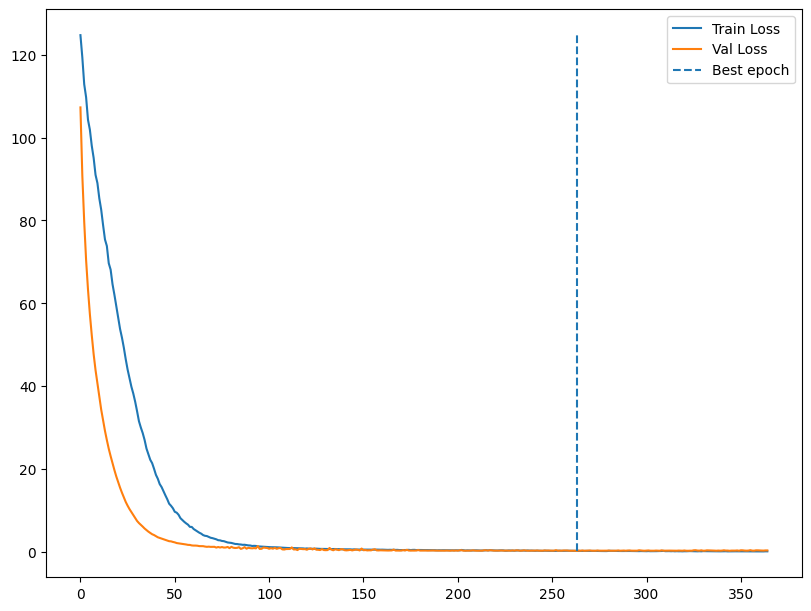

(20000, 555)
(20000,)
Train - f1=0.9600 recall=0.9897 precision=0.9320 log-loss=0.0403 opt-log-loss=0.0610
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2979 opt-log-loss=0.2428

-- Fold # 2/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1736 - Val: 0.2899 at epoch 316.
Restore the best model.


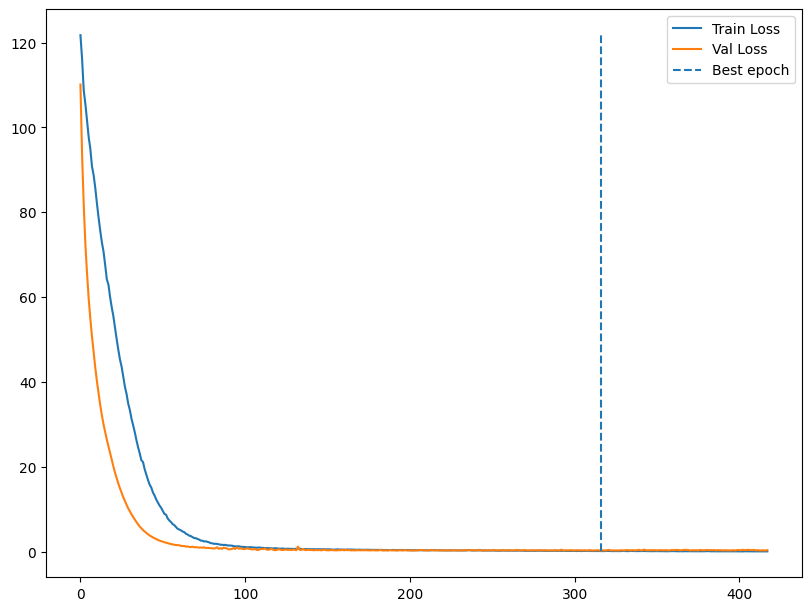

(20000, 555)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.0243 opt-log-loss=0.0405
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.3057 opt-log-loss=0.2698

-- Fold # 2/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4291 - Val: 0.2336 at epoch 189.
Restore the best model.


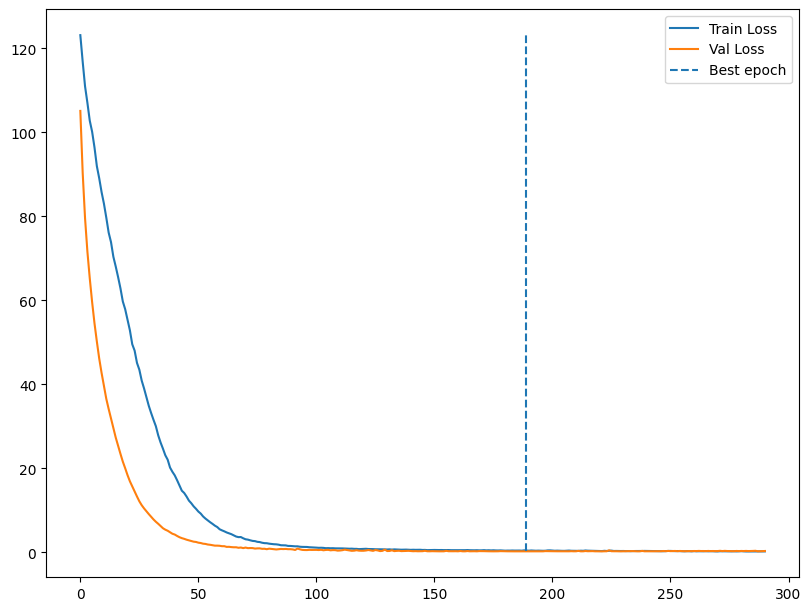

(20000, 555)
(20000,)
Train - f1=0.8122 recall=0.9588 precision=0.7045 log-loss=0.1678 opt-log-loss=0.2109
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.2069 opt-log-loss=0.1954

-- Fold # 3/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3905 - Val: 0.2600 at epoch 201.
Restore the best model.


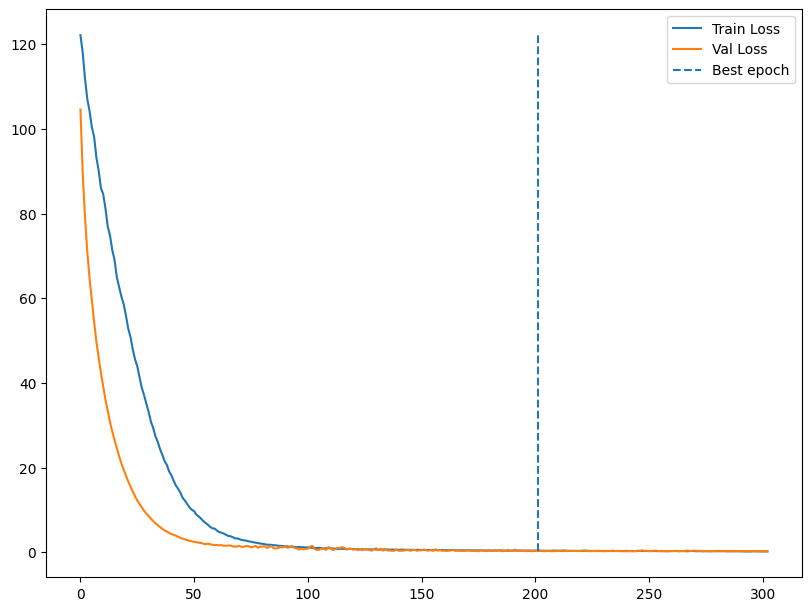

(20000, 555)
(20000,)
Train - f1=0.9307 recall=0.9691 precision=0.8952 log-loss=0.1457 opt-log-loss=0.1242
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.2750 opt-log-loss=0.2079

-- Fold # 3/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2258 - Val: 0.2926 at epoch 302.
Restore the best model.


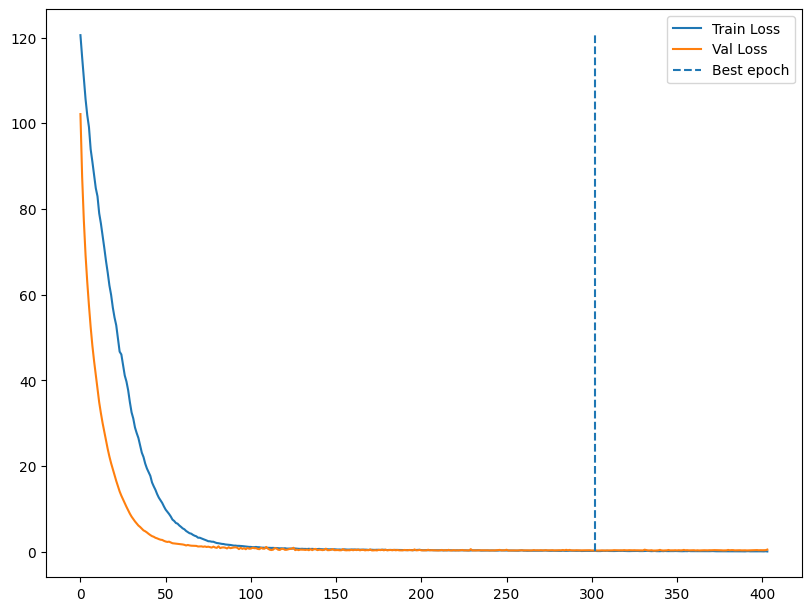

(20000, 555)
(20000,)
Train - f1=0.9794 recall=0.9794 precision=0.9794 log-loss=0.0519 opt-log-loss=0.0376
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.3371 opt-log-loss=0.2329

-- Fold # 3/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1431 - Val: 0.2537 at epoch 340.
Restore the best model.


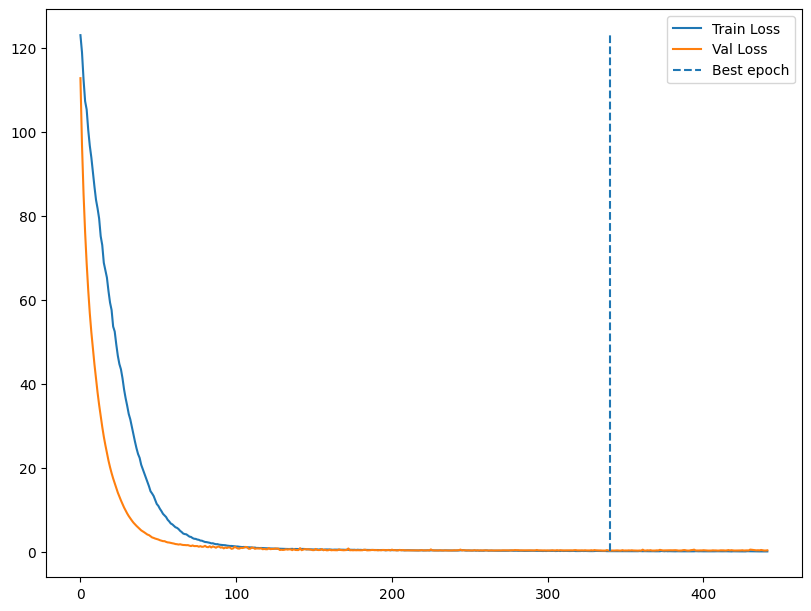

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0130 opt-log-loss=0.0133
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.4047 opt-log-loss=0.2891

-- Fold # 3/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2808 - Val: 0.3118 at epoch 249.
Restore the best model.


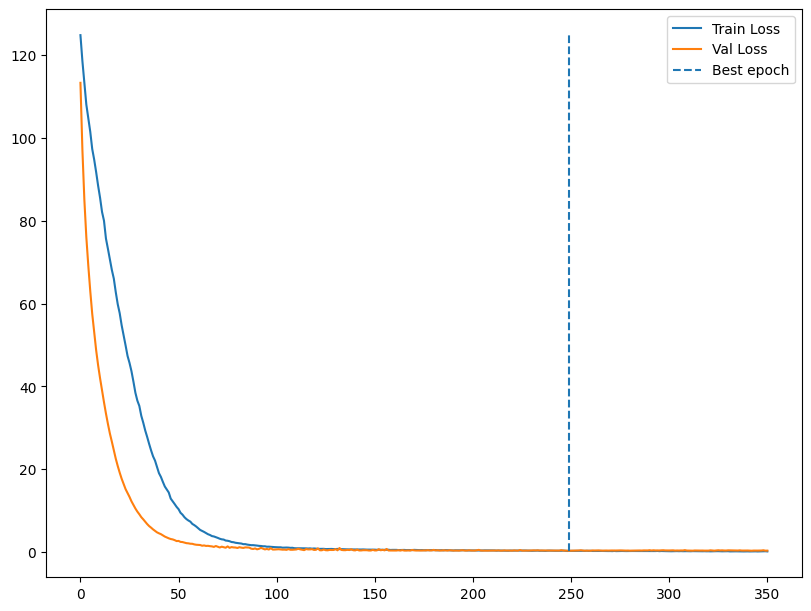

(20000, 555)
(20000,)
Train - f1=0.9592 recall=0.9691 precision=0.9495 log-loss=0.0845 opt-log-loss=0.0706
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.4294 opt-log-loss=0.2944

-- Fold # 3/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1969 - Val: 0.2891 at epoch 297.
Restore the best model.


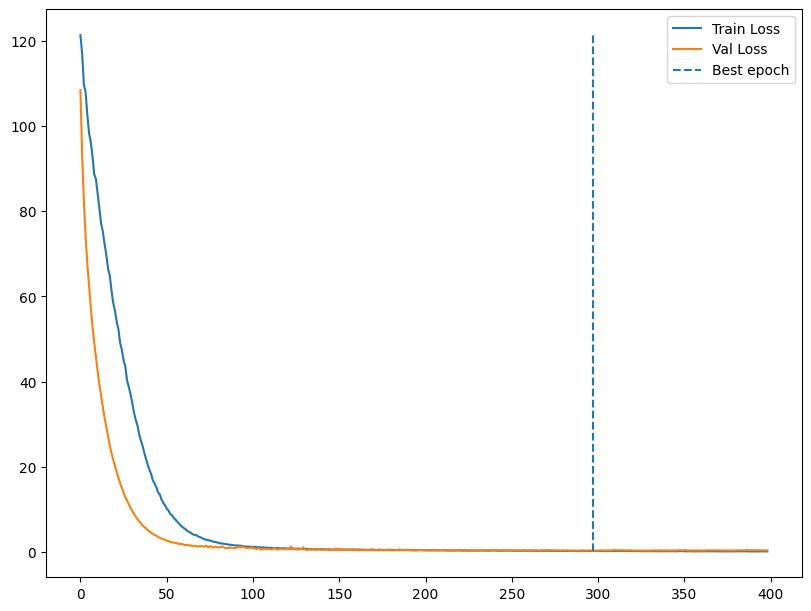

(20000, 555)
(20000,)
Train - f1=0.9741 recall=0.9691 precision=0.9792 log-loss=0.0581 opt-log-loss=0.0385
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3587 opt-log-loss=0.2771

-- Fold # 3/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3777 - Val: 0.2529 at epoch 198.
Restore the best model.


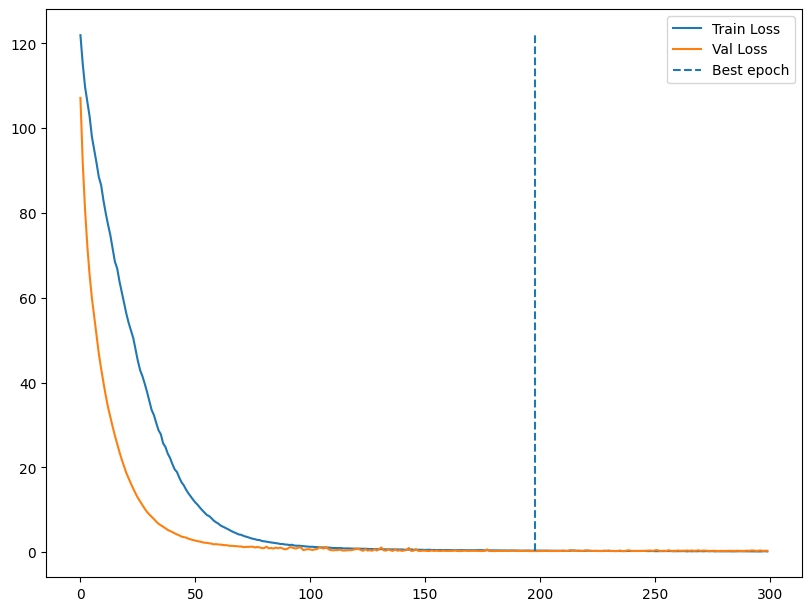

(20000, 555)
(20000,)
Train - f1=0.8966 recall=0.9381 precision=0.8585 log-loss=0.1480 opt-log-loss=0.1369
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.3125 opt-log-loss=0.2364

-- Fold # 3/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1640 - Val: 0.3007 at epoch 323.
Restore the best model.


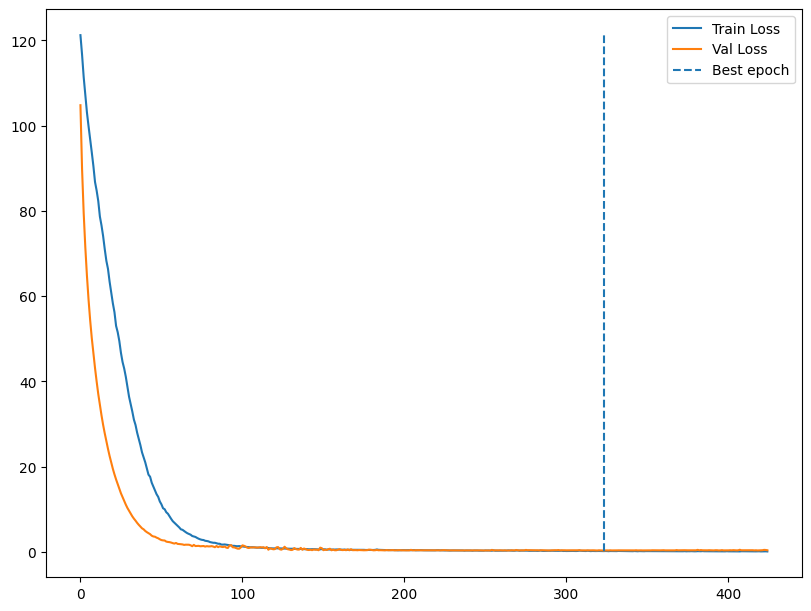

(20000, 555)
(20000,)
Train - f1=0.9845 recall=0.9794 precision=0.9896 log-loss=0.0488 opt-log-loss=0.0263
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4101 opt-log-loss=0.2640

-- Fold # 3/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2643 - Val: 0.2934 at epoch 270.
Restore the best model.


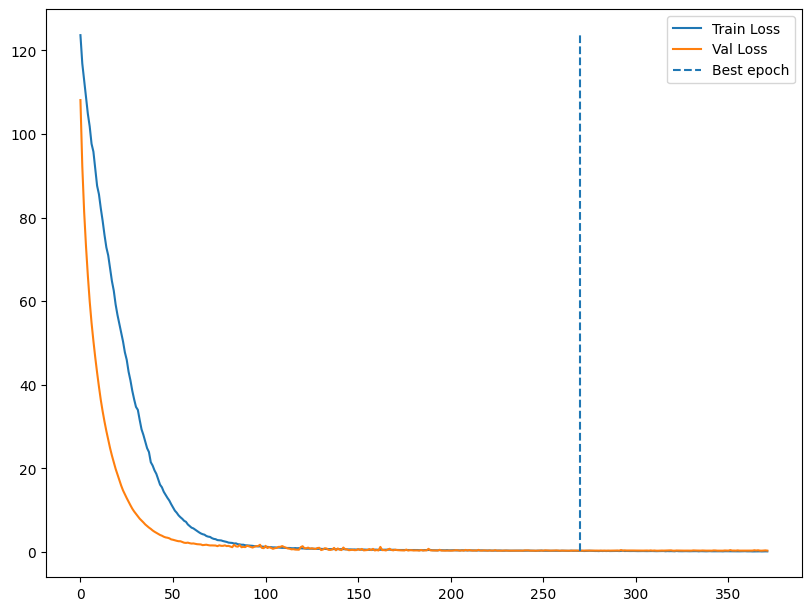

(20000, 555)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.0749 opt-log-loss=0.0659
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3842 opt-log-loss=0.2760

-- Fold # 3/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0360 - Val: 0.2395 at epoch 568.
Restore the best model.


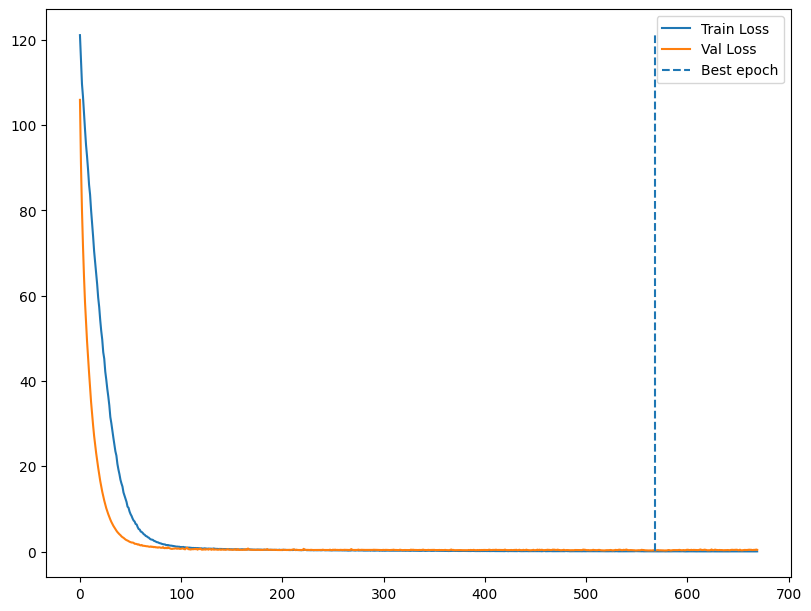

(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0031 opt-log-loss=0.0029
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4602 opt-log-loss=0.3041

-- Fold # 3/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1688 - Val: 0.3044 at epoch 309.
Restore the best model.


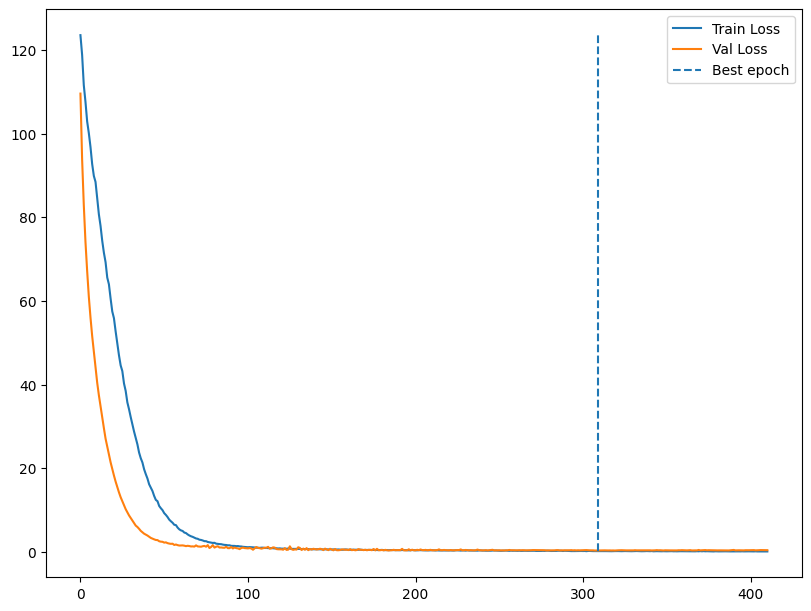

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0330 opt-log-loss=0.0239
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3924 opt-log-loss=0.2718

-- Fold # 4/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3308 - Val: 0.3084 at epoch 211.
Restore the best model.


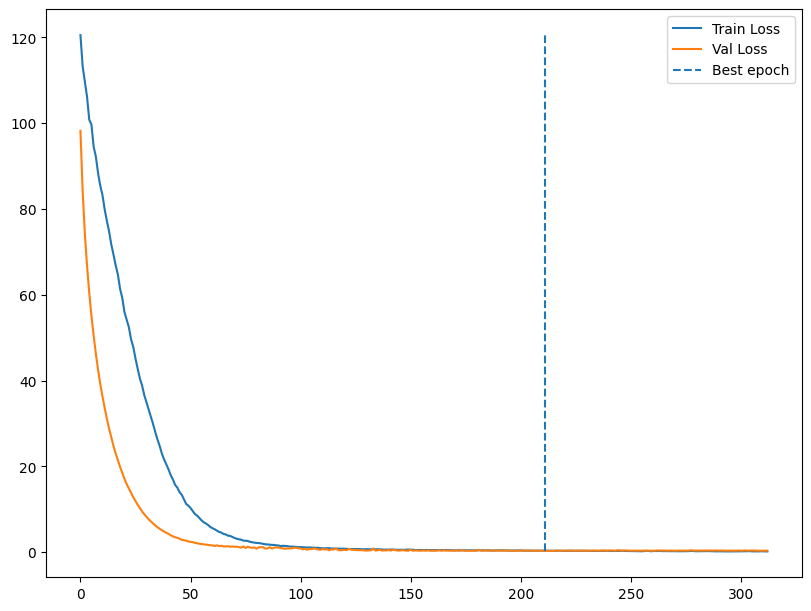

(20000, 555)
(20000,)
Train - f1=0.8867 recall=0.9278 precision=0.8491 log-loss=0.1800 opt-log-loss=0.1354
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3530 opt-log-loss=0.2728

-- Fold # 4/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4613 - Val: 0.2548 at epoch 183.
Restore the best model.


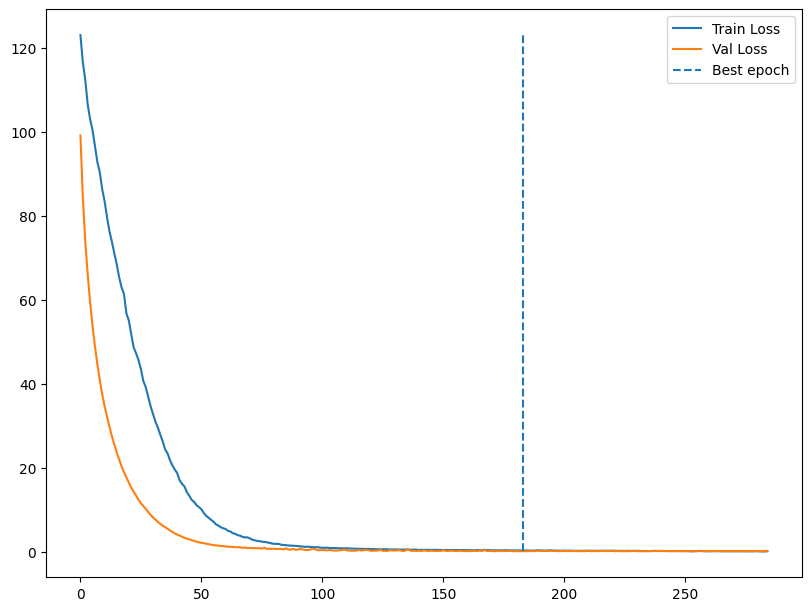

(20000, 555)
(20000,)
Train - f1=0.8634 recall=0.8144 precision=0.9186 log-loss=0.2677 opt-log-loss=0.1705
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2556 opt-log-loss=0.1836

-- Fold # 4/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3658 - Val: 0.2620 at epoch 220.
Restore the best model.


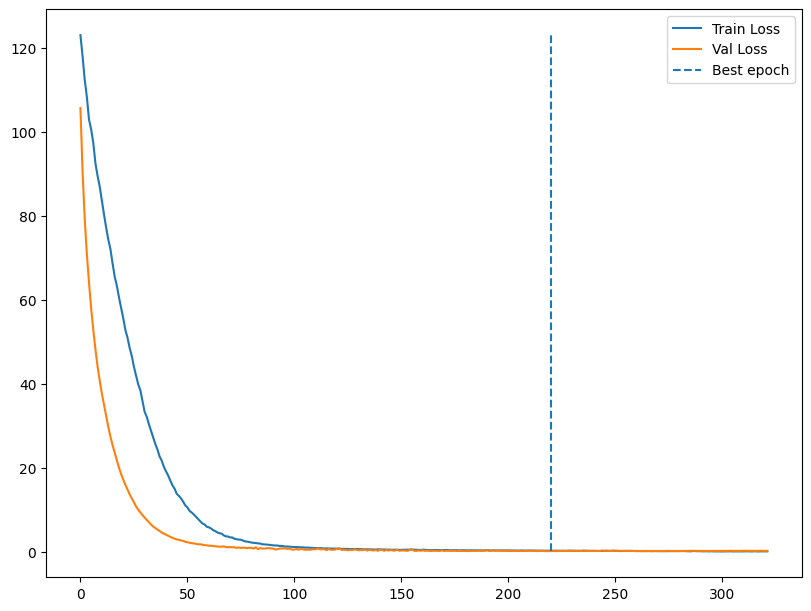

(20000, 555)
(20000,)
Train - f1=0.9146 recall=0.9381 precision=0.8922 log-loss=0.1768 opt-log-loss=0.1294
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2784 opt-log-loss=0.2006

-- Fold # 4/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3554 - Val: 0.2617 at epoch 210.
Restore the best model.


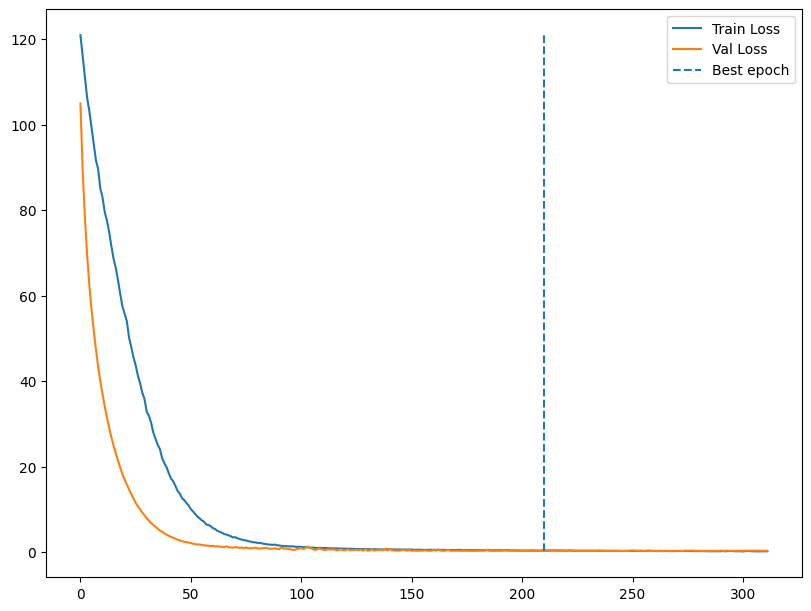

(20000, 555)
(20000,)
Train - f1=0.9100 recall=0.9381 precision=0.8835 log-loss=0.1672 opt-log-loss=0.1409
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.2520 opt-log-loss=0.1982

-- Fold # 4/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3017 - Val: 0.2974 at epoch 236.
Restore the best model.


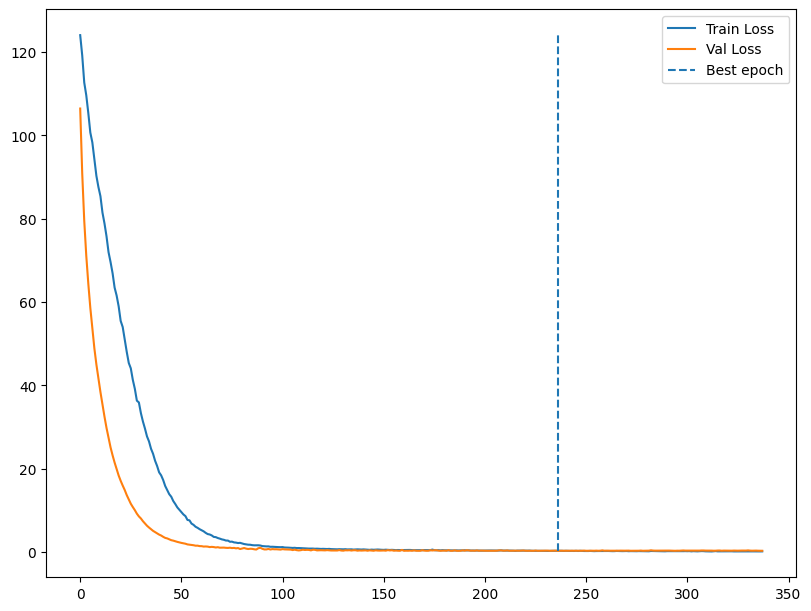

(20000, 555)
(20000,)
Train - f1=0.9400 recall=0.9691 precision=0.9126 log-loss=0.1199 opt-log-loss=0.0948
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.4016 opt-log-loss=0.3081

-- Fold # 4/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4467 - Val: 0.3079 at epoch 178.
Restore the best model.


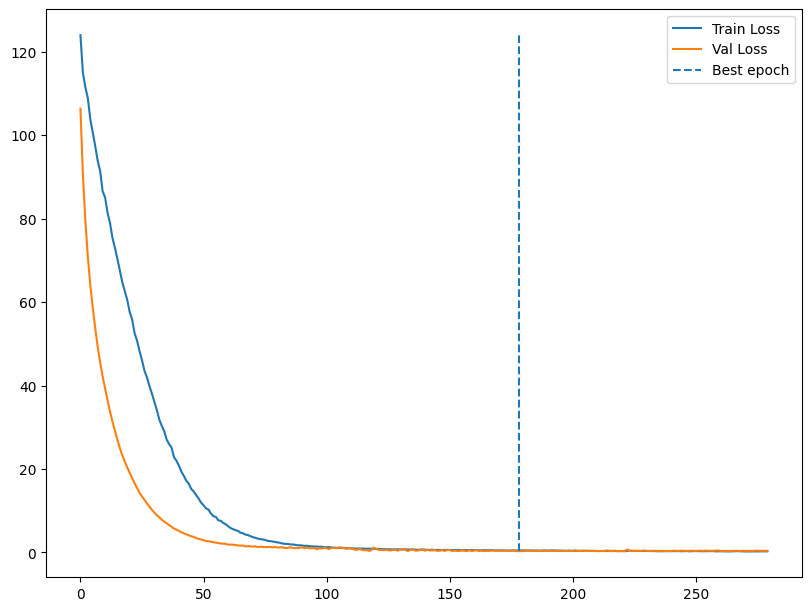

(20000, 555)
(20000,)
Train - f1=0.7636 recall=0.6495 precision=0.9265 log-loss=0.4020 opt-log-loss=0.2140
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.3996 opt-log-loss=0.2923

-- Fold # 4/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3790 - Val: 0.2623 at epoch 204.
Restore the best model.


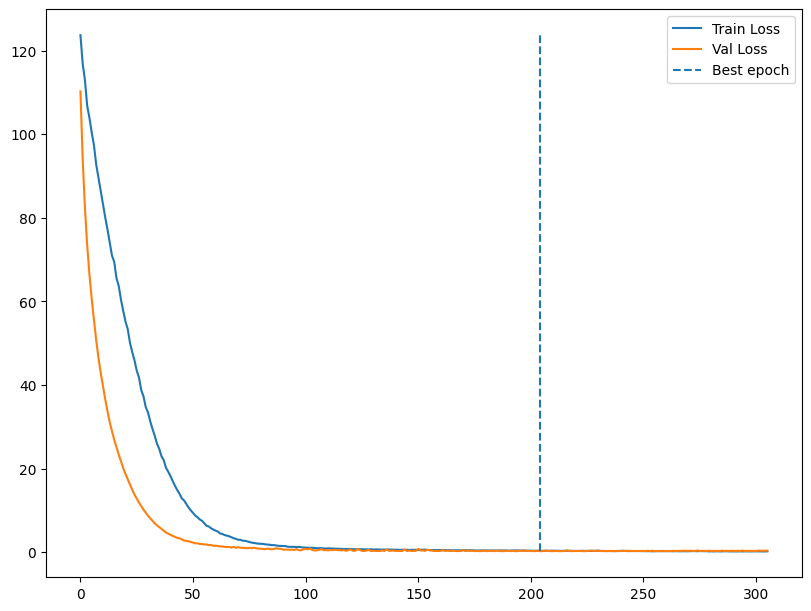

(20000, 555)
(20000,)
Train - f1=0.8718 recall=0.8763 precision=0.8673 log-loss=0.2128 opt-log-loss=0.1439
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.2911 opt-log-loss=0.2114

-- Fold # 4/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4910 - Val: 0.2830 at epoch 163.
Restore the best model.


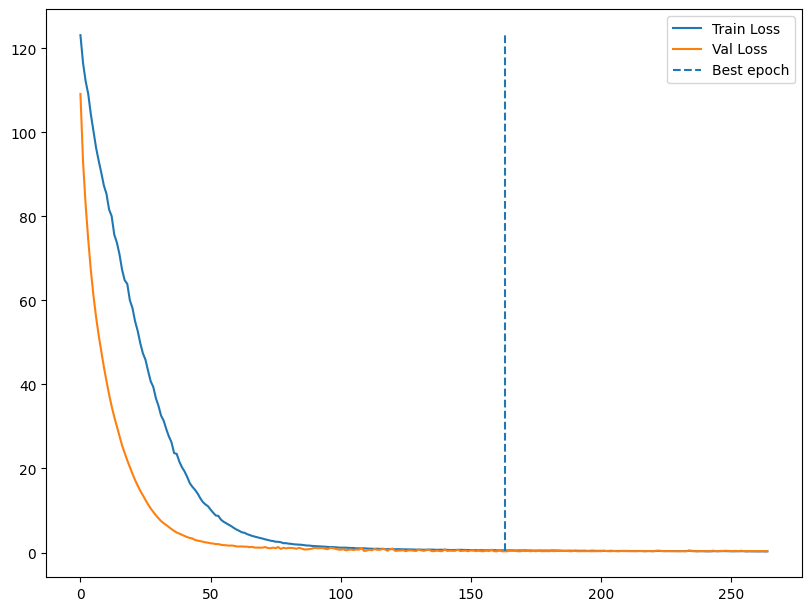

(20000, 555)
(20000,)
Train - f1=0.8543 recall=0.8763 precision=0.8333 log-loss=0.2624 opt-log-loss=0.2039
(20000, 62)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.2718 opt-log-loss=0.2200

-- Fold # 4/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2922 - Val: 0.2203 at epoch 236.
Restore the best model.


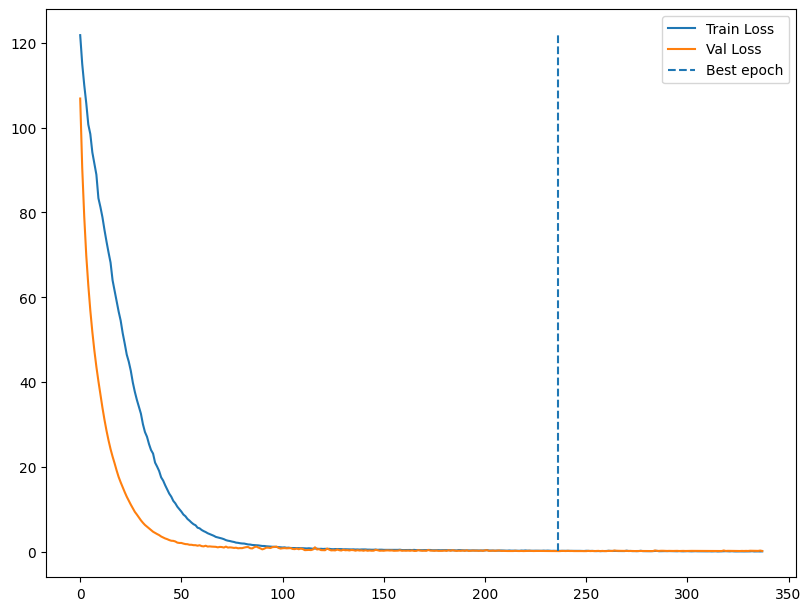

(20000, 555)
(20000,)
Train - f1=0.9442 recall=0.9588 precision=0.9300 log-loss=0.1352 opt-log-loss=0.1011
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.2127 opt-log-loss=0.1598

-- Fold # 4/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4486 - Val: 0.2680 at epoch 177.
Restore the best model.


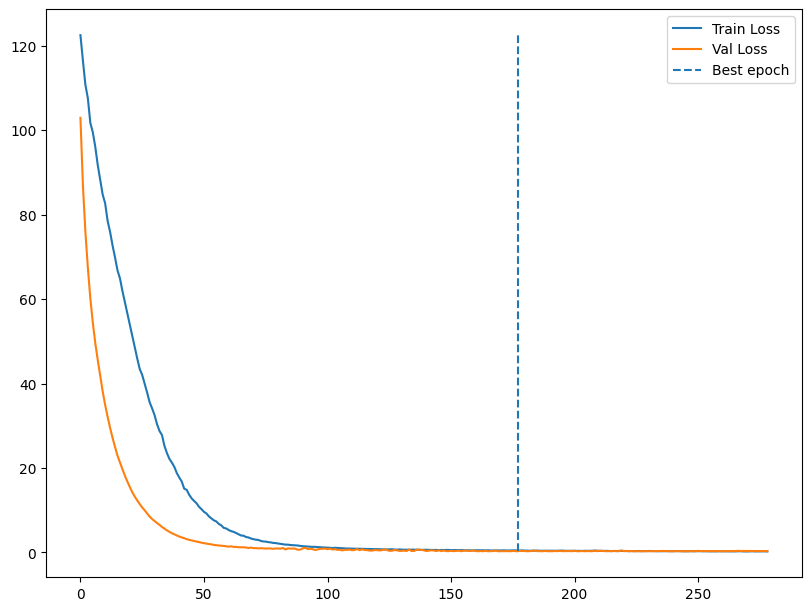

(20000, 555)
(20000,)
Train - f1=0.8421 recall=0.8247 precision=0.8602 log-loss=0.2910 opt-log-loss=0.1894
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3354 opt-log-loss=0.2467

-- Fold # 5/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2745 - Val: 0.1795 at epoch 254.
Restore the best model.


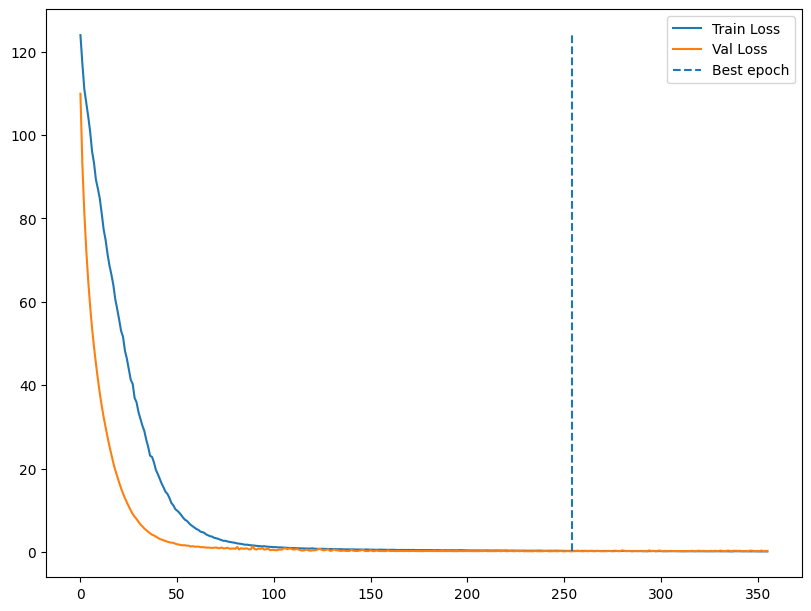

(20000, 555)
(20000,)
Train - f1=0.9038 recall=0.9691 precision=0.8468 log-loss=0.0656 opt-log-loss=0.0940
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.1423 opt-log-loss=0.1123

-- Fold # 5/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2719 - Val: 0.1979 at epoch 270.
Restore the best model.


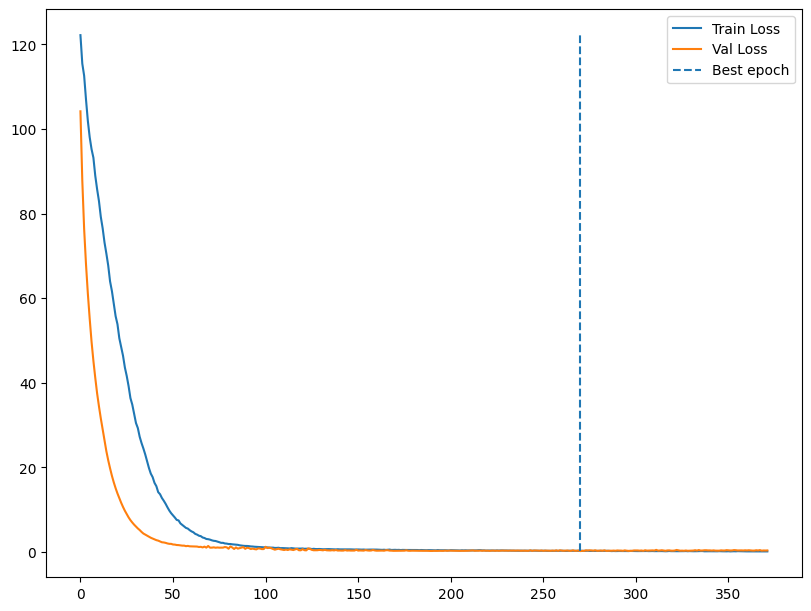

(20000, 555)
(20000,)
Train - f1=0.8818 recall=1.0000 precision=0.7886 log-loss=0.0716 opt-log-loss=0.1190
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.1199 opt-log-loss=0.1095

-- Fold # 5/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2113 - Val: 0.1980 at epoch 303.
Restore the best model.


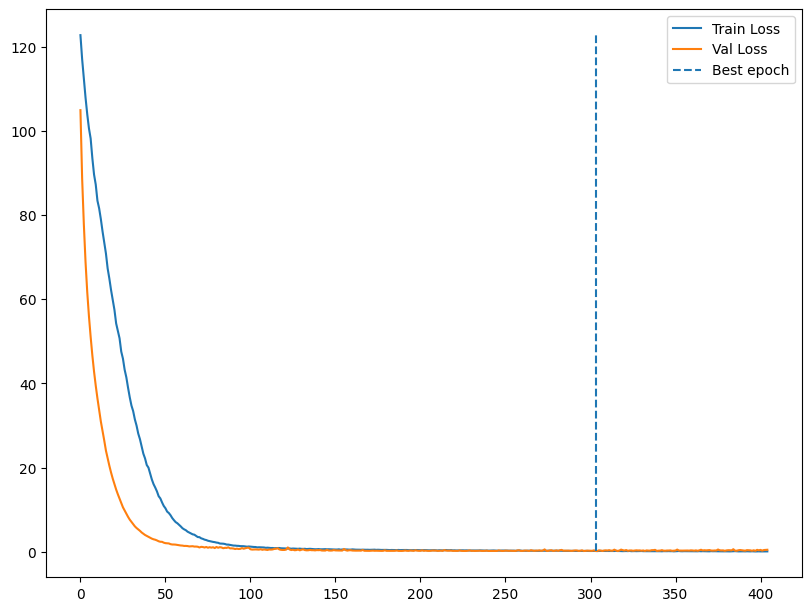

(20000, 555)
(20000,)
Train - f1=0.9848 recall=1.0000 precision=0.9700 log-loss=0.0279 opt-log-loss=0.0393
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.1939 opt-log-loss=0.1259

-- Fold # 5/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2165 - Val: 0.2461 at epoch 282.
Restore the best model.


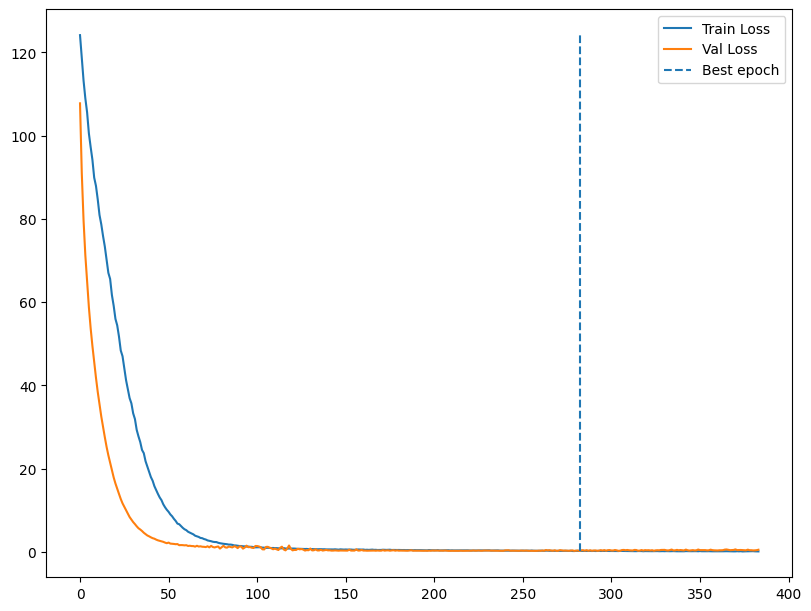

(20000, 555)
(20000,)
Train - f1=0.9366 recall=0.9897 precision=0.8889 log-loss=0.0467 opt-log-loss=0.0700
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.2576 opt-log-loss=0.1752

-- Fold # 5/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2999 - Val: 0.2378 at epoch 252.
Restore the best model.


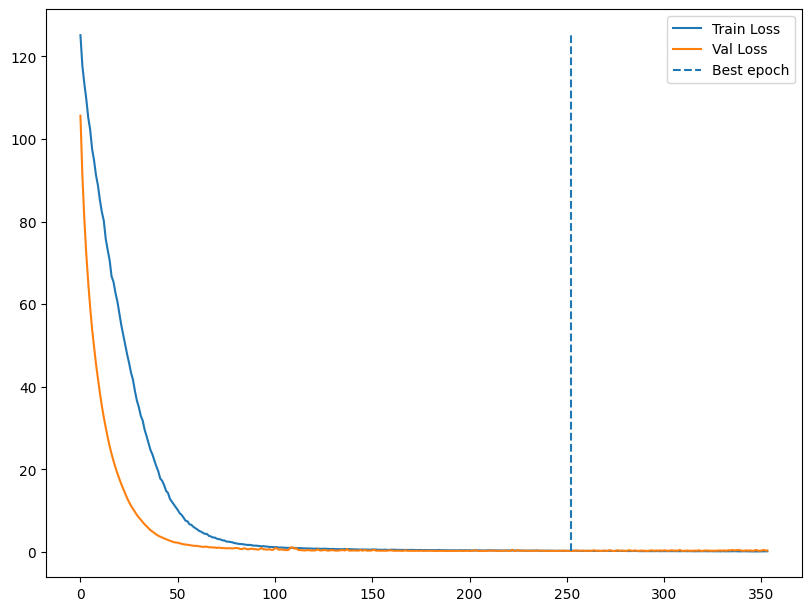

(20000, 555)
(20000,)
Train - f1=0.8688 recall=0.9897 precision=0.7742 log-loss=0.0940 opt-log-loss=0.1390
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2426 opt-log-loss=0.2127

-- Fold # 5/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2266 - Val: 0.2086 at epoch 278.
Restore the best model.


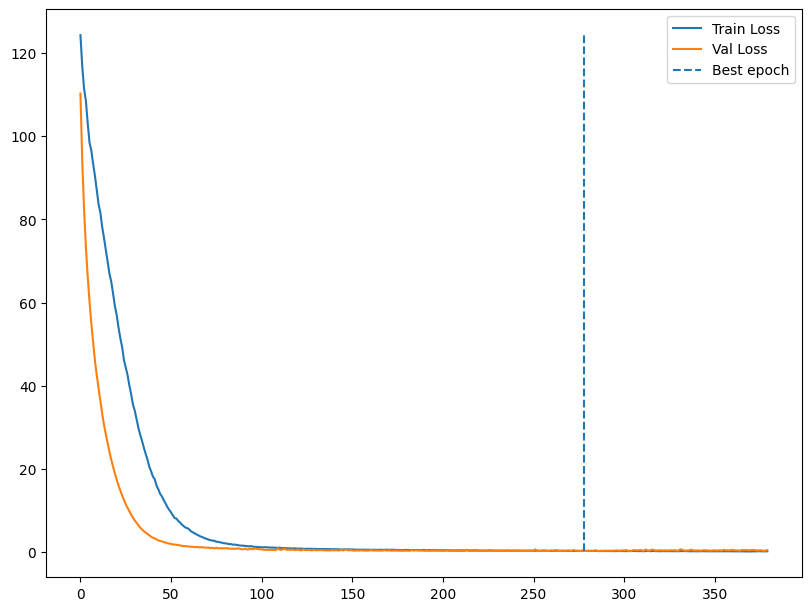

(20000, 555)
(20000,)
Train - f1=0.9417 recall=1.0000 precision=0.8899 log-loss=0.0336 opt-log-loss=0.0656
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2199 opt-log-loss=0.1604

-- Fold # 5/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2668 - Val: 0.1983 at epoch 251.
Restore the best model.


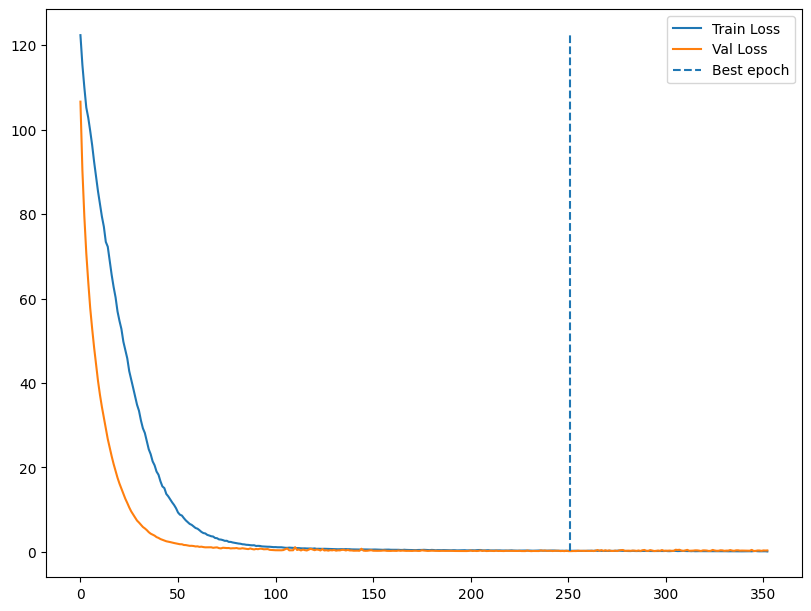

(20000, 555)
(20000,)
Train - f1=0.9282 recall=1.0000 precision=0.8661 log-loss=0.0603 opt-log-loss=0.0858
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2592 opt-log-loss=0.1882

-- Fold # 5/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4331 - Val: 0.1728 at epoch 178.
Restore the best model.


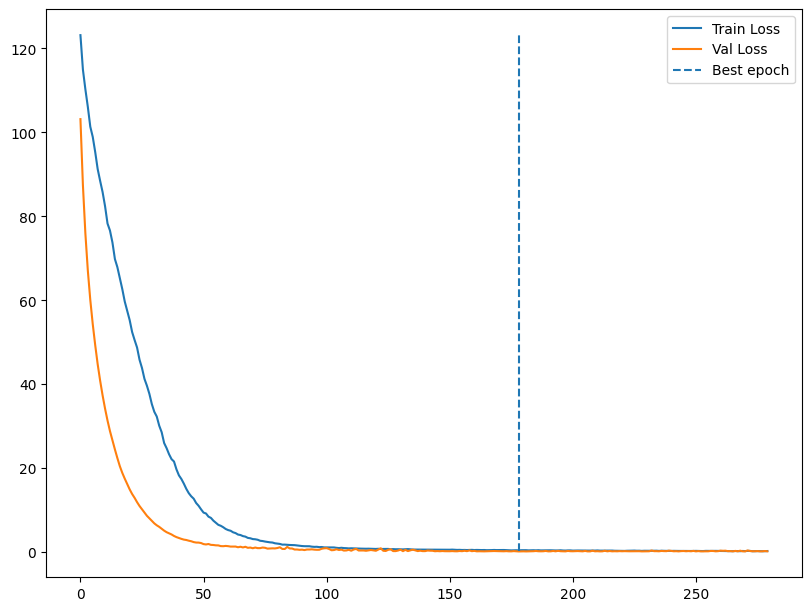

(20000, 555)
(20000,)
Train - f1=0.8402 recall=0.9485 precision=0.7541 log-loss=0.1474 opt-log-loss=0.1830
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.1701 opt-log-loss=0.1391

-- Fold # 5/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2514 - Val: 0.2381 at epoch 273.
Restore the best model.


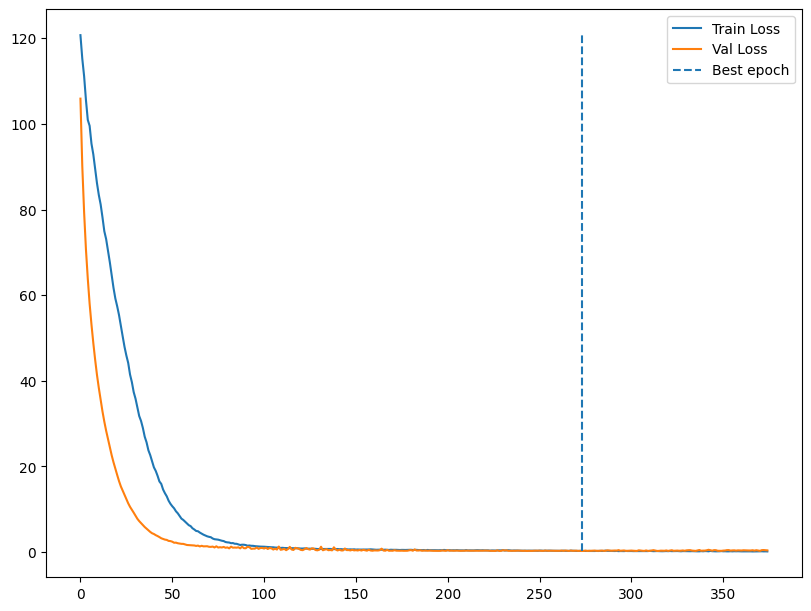

(20000, 555)
(20000,)
Train - f1=0.9143 recall=0.9897 precision=0.8496 log-loss=0.0545 opt-log-loss=0.0911
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.2673 opt-log-loss=0.1820

-- Fold # 5/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1945 - Val: 0.2168 at epoch 310.
Restore the best model.


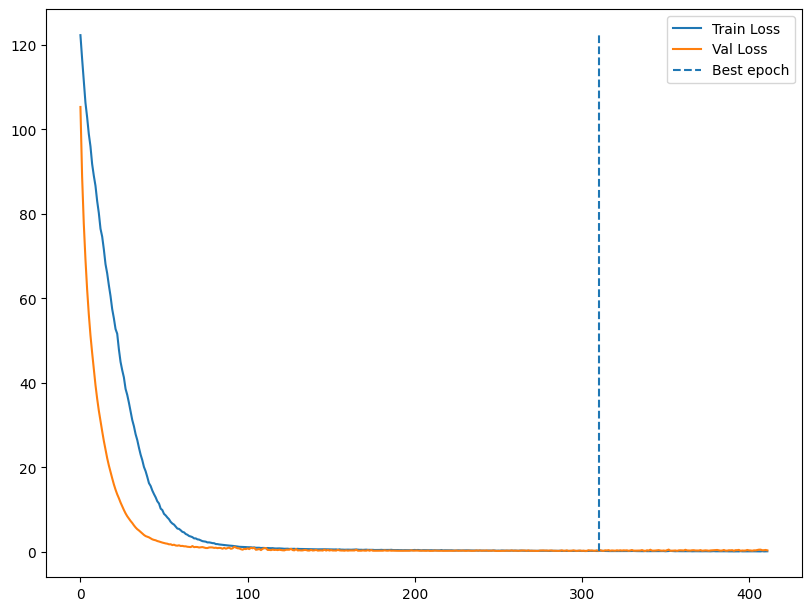

(20000, 555)
(20000,)
Train - f1=0.9848 recall=1.0000 precision=0.9700 log-loss=0.0178 opt-log-loss=0.0348
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.2228 opt-log-loss=0.1435

-- Fold # 6/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1660 - Val: 0.4676 at epoch 343.
Restore the best model.


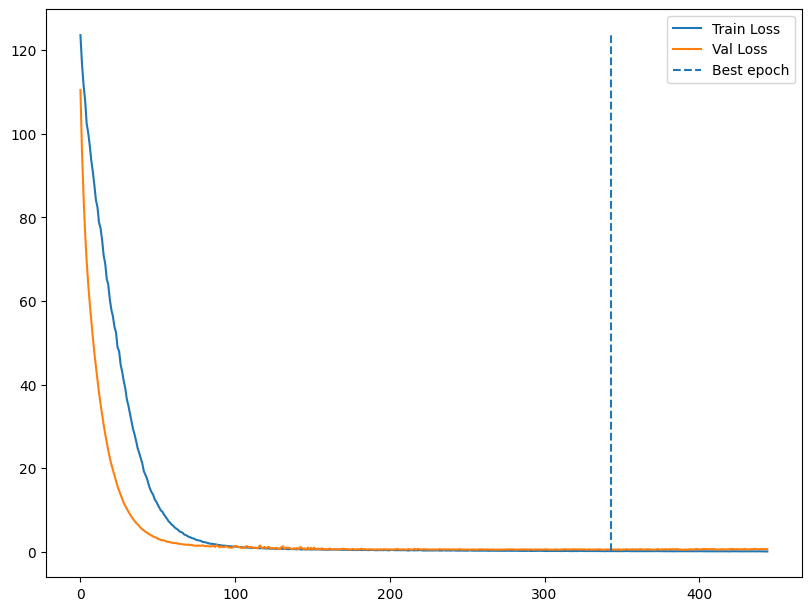

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0174 opt-log-loss=0.0185
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.7248 opt-log-loss=0.5717

-- Fold # 6/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4560 - Val: 0.4571 at epoch 164.
Restore the best model.


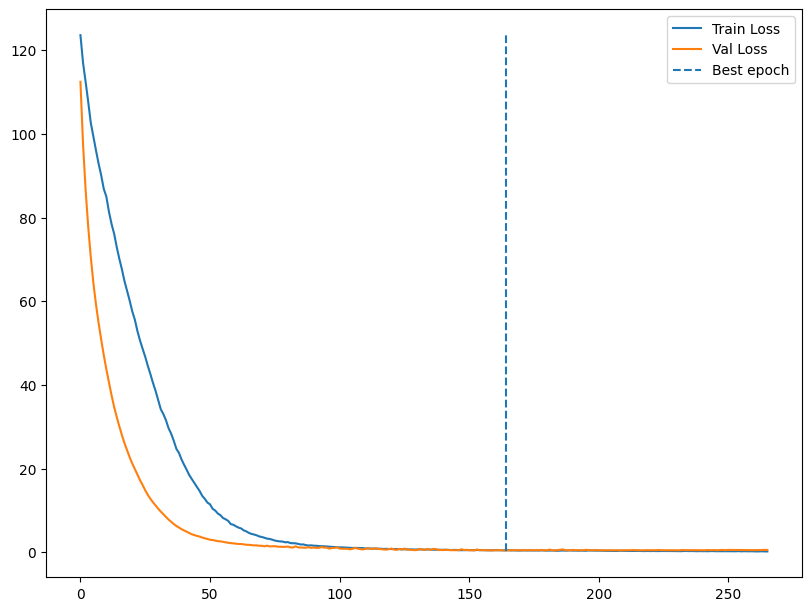

(20000, 555)
(20000,)
Train - f1=0.8770 recall=0.8454 precision=0.9111 log-loss=0.2774 opt-log-loss=0.1896
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.6236 opt-log-loss=0.4372

-- Fold # 6/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4779 - Val: 0.3774 at epoch 163.
Restore the best model.


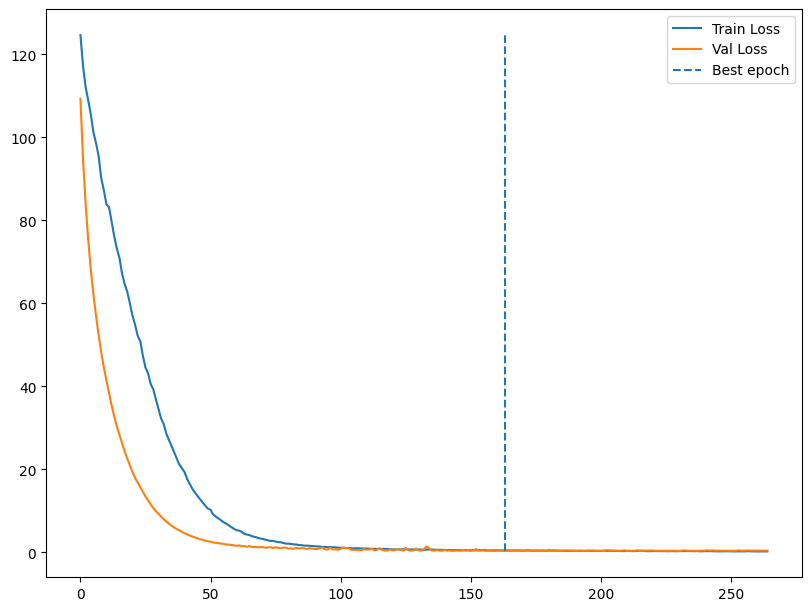

(20000, 555)
(20000,)
Train - f1=0.8308 recall=0.8351 precision=0.8265 log-loss=0.2817 opt-log-loss=0.2118
(20000, 62)
(20000,)
Test  - f1=0.6400 recall=0.7273 precision=0.5714 log-loss=0.4321 opt-log-loss=0.3387

-- Fold # 6/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3817 - Val: 0.4432 at epoch 188.
Restore the best model.


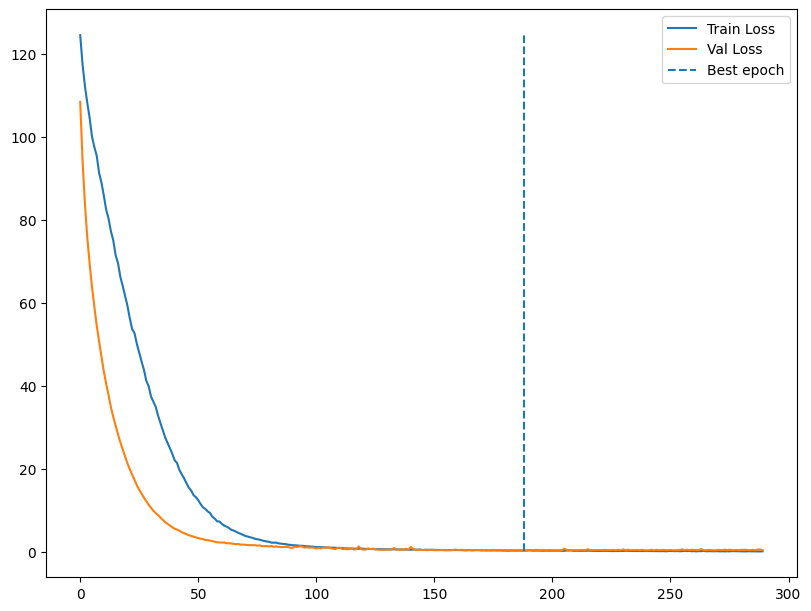

(20000, 555)
(20000,)
Train - f1=0.8641 recall=0.9175 precision=0.8165 log-loss=0.1861 opt-log-loss=0.1759
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.5101 opt-log-loss=0.3980

-- Fold # 6/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1140 - Val: 0.4203 at epoch 407.
Restore the best model.


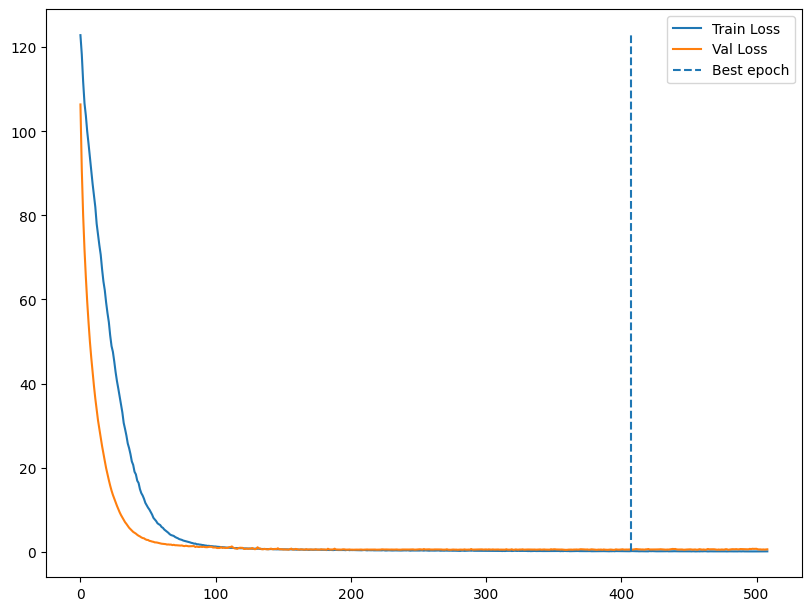

(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0087 opt-log-loss=0.0180
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.6256 opt-log-loss=0.5377

-- Fold # 6/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3342 - Val: 0.4640 at epoch 241.
Restore the best model.


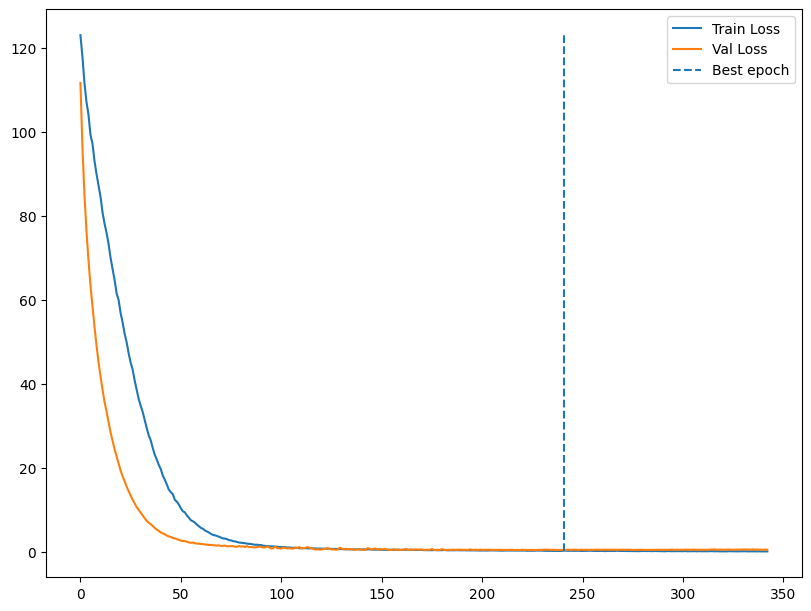

(20000, 555)
(20000,)
Train - f1=0.9637 recall=0.9588 precision=0.9688 log-loss=0.1483 opt-log-loss=0.1027
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.5845 opt-log-loss=0.4464

-- Fold # 6/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3727 - Val: 0.4856 at epoch 206.
Restore the best model.


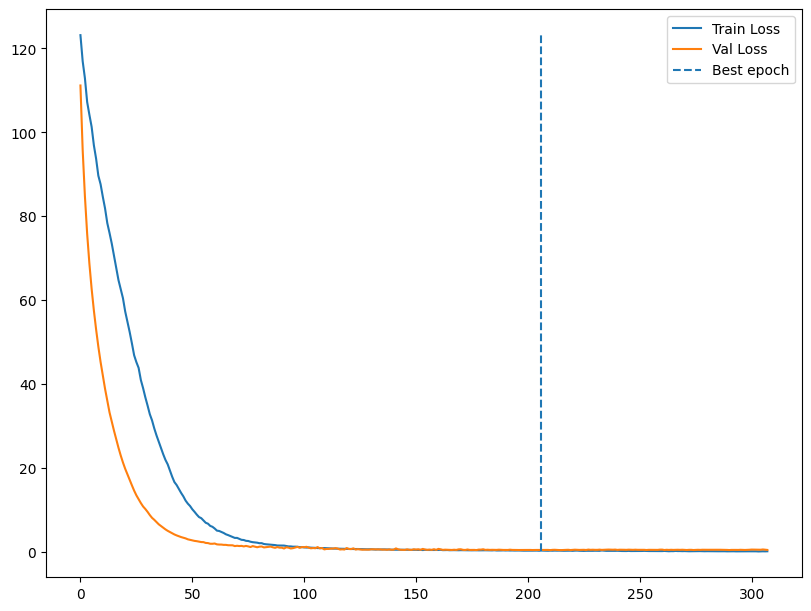

(20000, 555)
(20000,)
Train - f1=0.9184 recall=0.9278 precision=0.9091 log-loss=0.1740 opt-log-loss=0.1347
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.6784 opt-log-loss=0.5171

-- Fold # 6/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2106 - Val: 0.3685 at epoch 312.
Restore the best model.


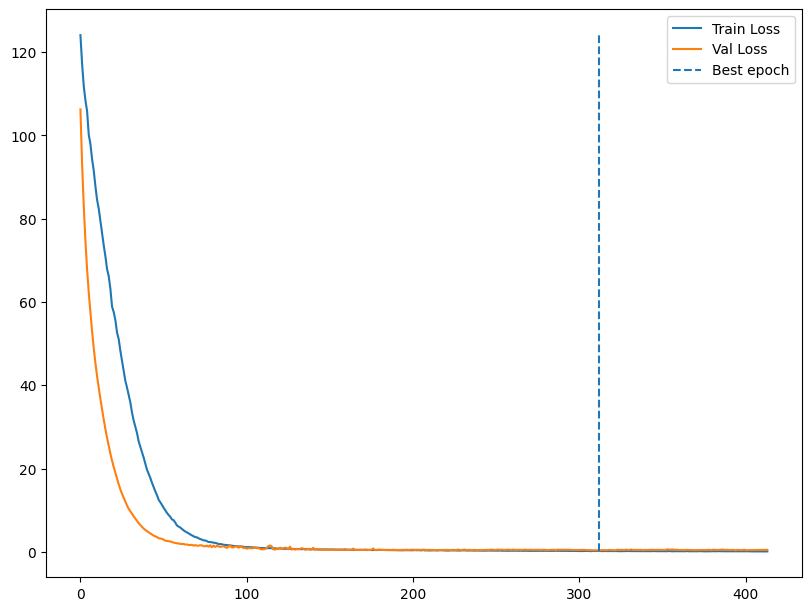

(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0404 opt-log-loss=0.0327
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.5622 opt-log-loss=0.4211

-- Fold # 6/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2707 - Val: 0.3866 at epoch 218.
Restore the best model.


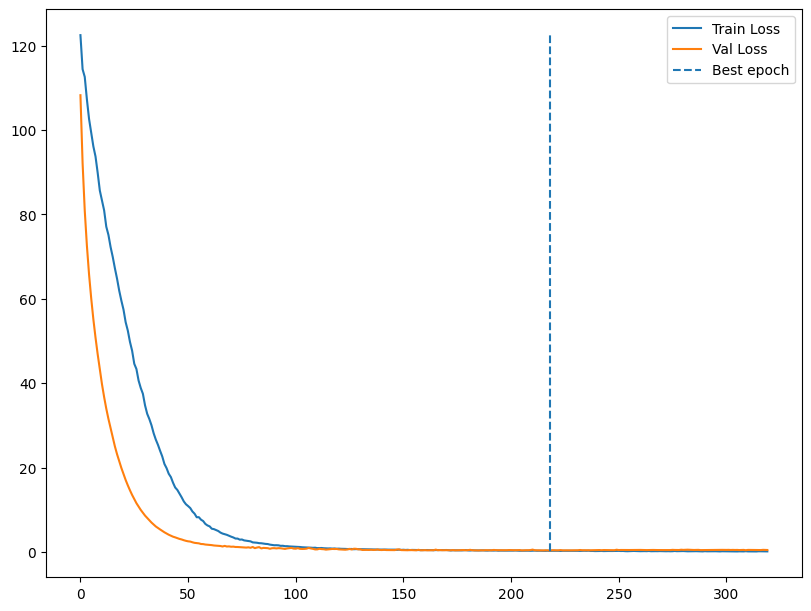

(20000, 555)
(20000,)
Train - f1=0.9340 recall=0.9485 precision=0.9200 log-loss=0.1423 opt-log-loss=0.1031
(20000, 62)
(20000,)
Test  - f1=0.6364 recall=0.6364 precision=0.6364 log-loss=0.5787 opt-log-loss=0.4381

-- Fold # 6/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2710 - Val: 0.4881 at epoch 246.
Restore the best model.


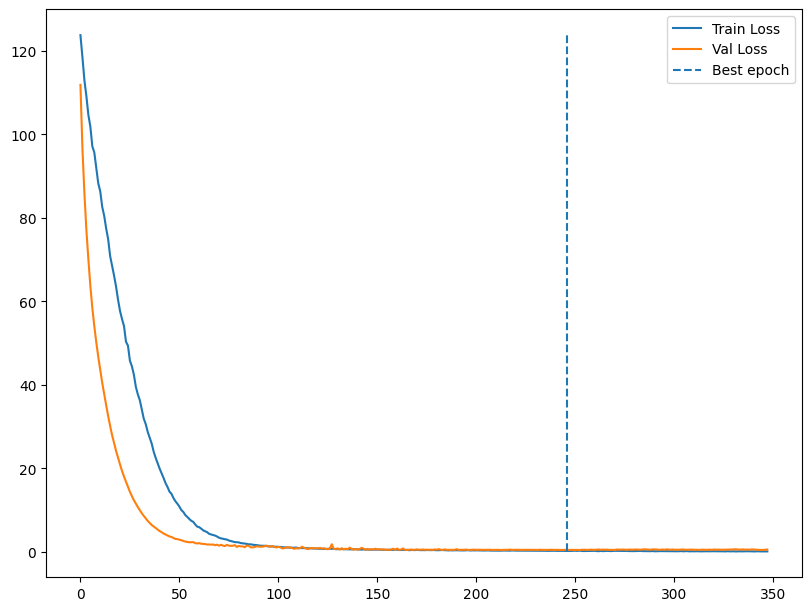

(20000, 555)
(20000,)
Train - f1=0.9490 recall=0.9588 precision=0.9394 log-loss=0.1118 opt-log-loss=0.0804
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.7794 opt-log-loss=0.5710

-- Fold # 7/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4501 - Val: 0.4876 at epoch 184.
Restore the best model.


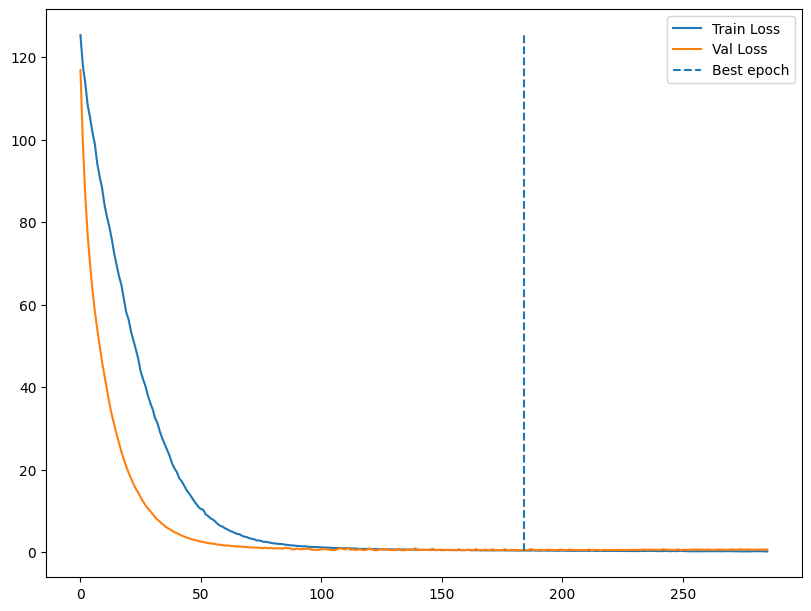

(20000, 555)
(20000,)
Train - f1=0.8473 recall=0.8866 precision=0.8113 log-loss=0.2378 opt-log-loss=0.2024
(20000, 62)
(20000,)
Test  - f1=0.4211 recall=0.3636 precision=0.5000 log-loss=0.7793 opt-log-loss=0.5736

-- Fold # 7/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.7732 - Val: 0.4754 at epoch 123.
Restore the best model.


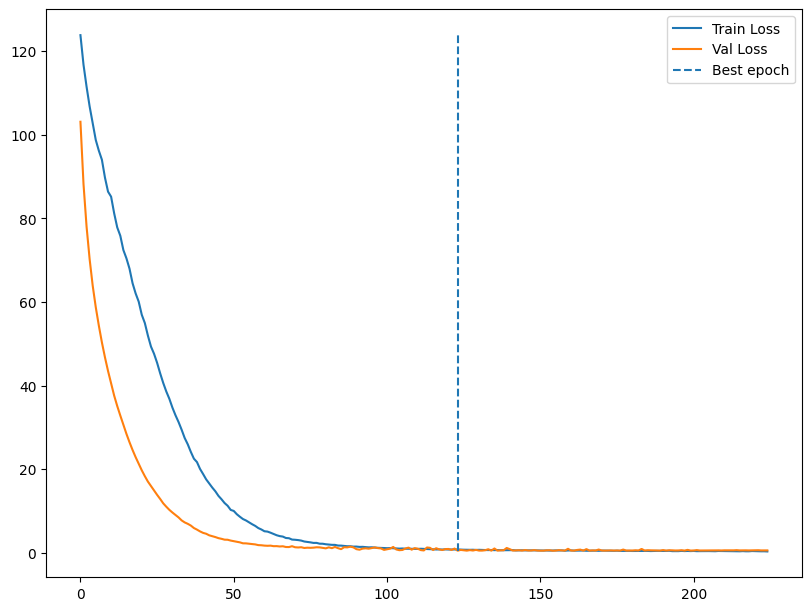

(20000, 555)
(20000,)
Train - f1=0.7600 recall=0.7835 precision=0.7379 log-loss=0.3276 opt-log-loss=0.2838
(20000, 62)
(20000,)
Test  - f1=0.5000 recall=0.4545 precision=0.5556 log-loss=0.6472 opt-log-loss=0.4880

-- Fold # 7/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5478 - Val: 0.4712 at epoch 158.
Restore the best model.


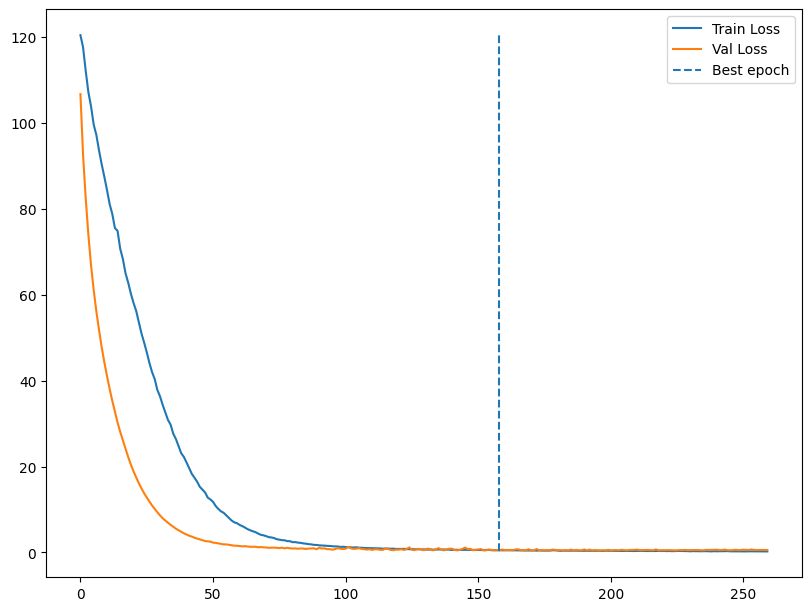

(20000, 555)
(20000,)
Train - f1=0.8155 recall=0.8660 precision=0.7706 log-loss=0.2648 opt-log-loss=0.2367
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.7350 opt-log-loss=0.5452

-- Fold # 7/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.6519 - Val: 0.5571 at epoch 131.
Restore the best model.


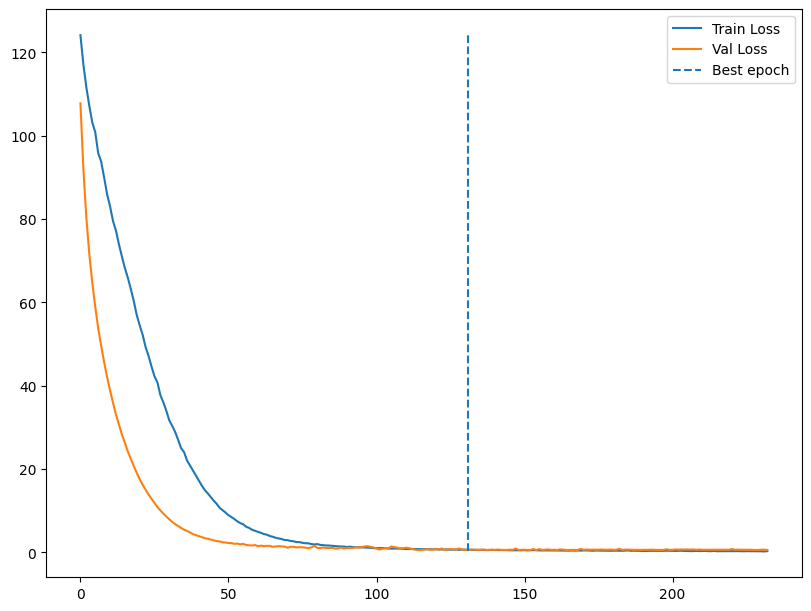

(20000, 555)
(20000,)
Train - f1=0.8163 recall=0.8247 precision=0.8081 log-loss=0.3062 opt-log-loss=0.2476
(20000, 62)
(20000,)
Test  - f1=0.5263 recall=0.4545 precision=0.6250 log-loss=0.9318 opt-log-loss=0.7004

-- Fold # 7/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.5941 - Val: 0.4871 at epoch 145.
Restore the best model.


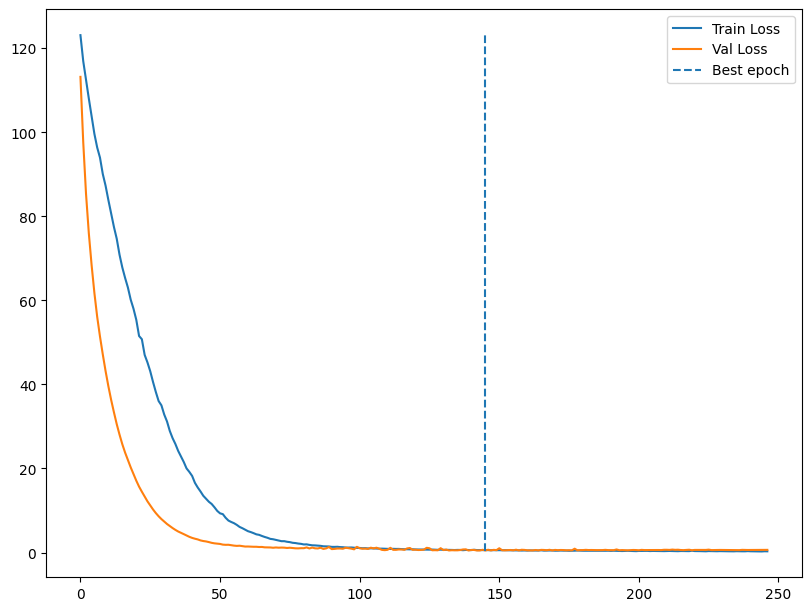

(20000, 555)
(20000,)
Train - f1=0.8000 recall=0.8660 precision=0.7434 log-loss=0.2925 opt-log-loss=0.2460
(20000, 62)
(20000,)
Test  - f1=0.5263 recall=0.4545 precision=0.6250 log-loss=0.8184 opt-log-loss=0.5903

-- Fold # 7/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.6411 - Val: 0.5640 at epoch 139.
Restore the best model.


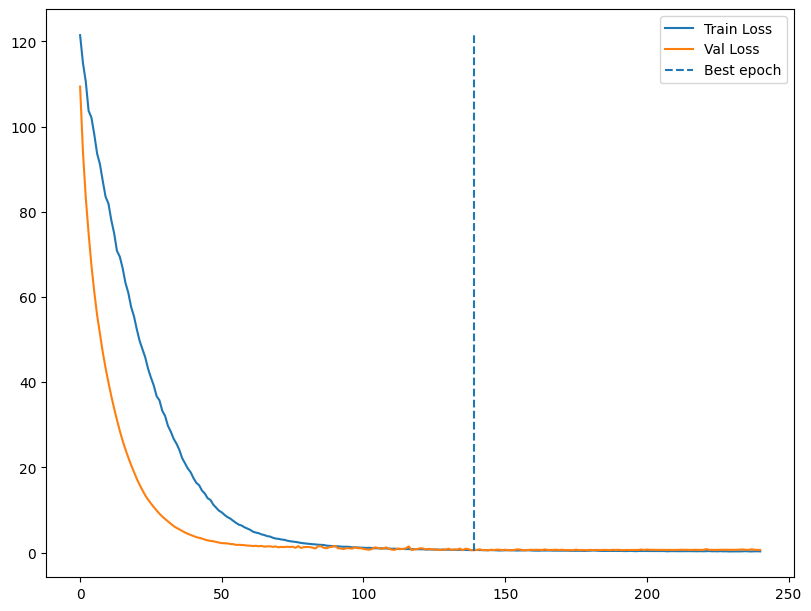

(20000, 555)
(20000,)
Train - f1=0.7982 recall=0.8969 precision=0.7190 log-loss=0.2874 opt-log-loss=0.2851
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.9684 opt-log-loss=0.7679

-- Fold # 7/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3997 - Val: 0.5518 at epoch 206.
Restore the best model.


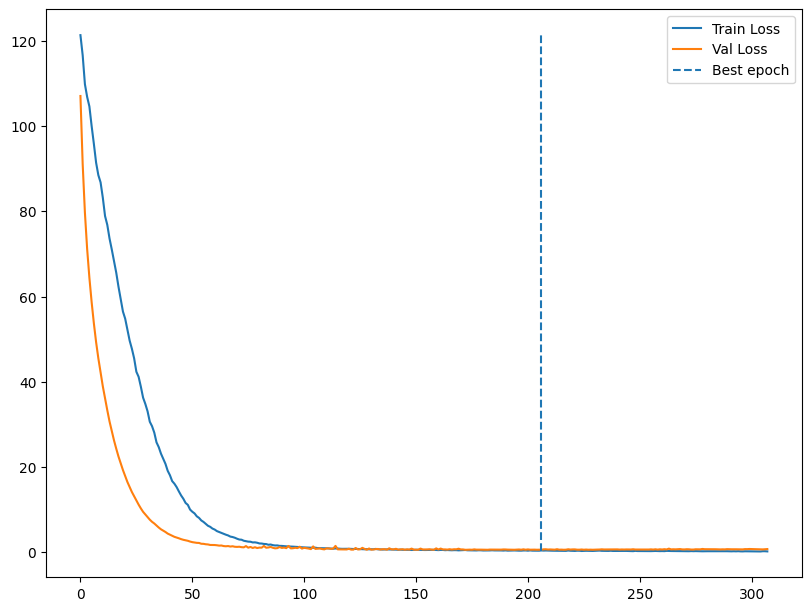

(20000, 555)
(20000,)
Train - f1=0.9231 recall=0.9278 precision=0.9184 log-loss=0.1581 opt-log-loss=0.1175
(20000, 62)
(20000,)
Test  - f1=0.5556 recall=0.4545 precision=0.7143 log-loss=1.0334 opt-log-loss=0.7236

-- Fold # 7/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4236 - Val: 0.4609 at epoch 196.
Restore the best model.


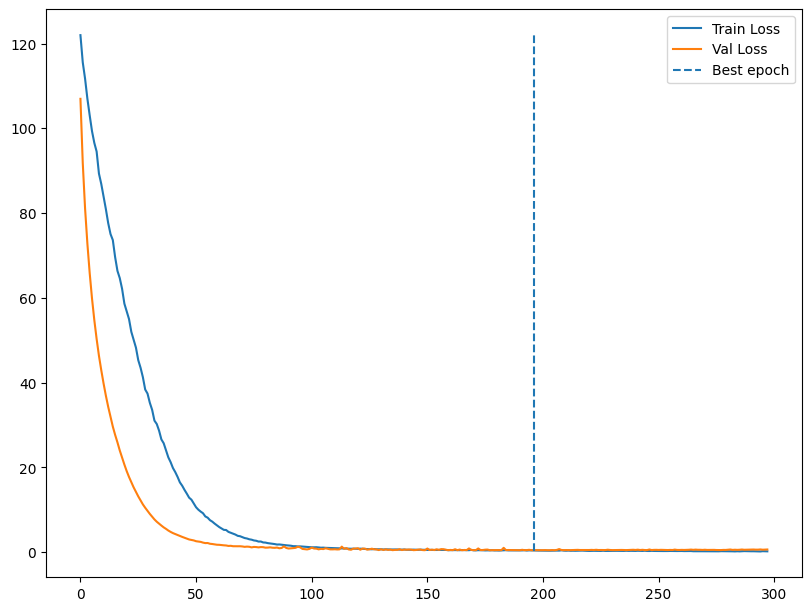

(20000, 555)
(20000,)
Train - f1=0.8868 recall=0.9691 precision=0.8174 log-loss=0.1715 opt-log-loss=0.1801
(20000, 62)
(20000,)
Test  - f1=0.6087 recall=0.6364 precision=0.5833 log-loss=0.6600 opt-log-loss=0.5564

-- Fold # 7/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.6257 - Val: 0.4562 at epoch 141.
Restore the best model.


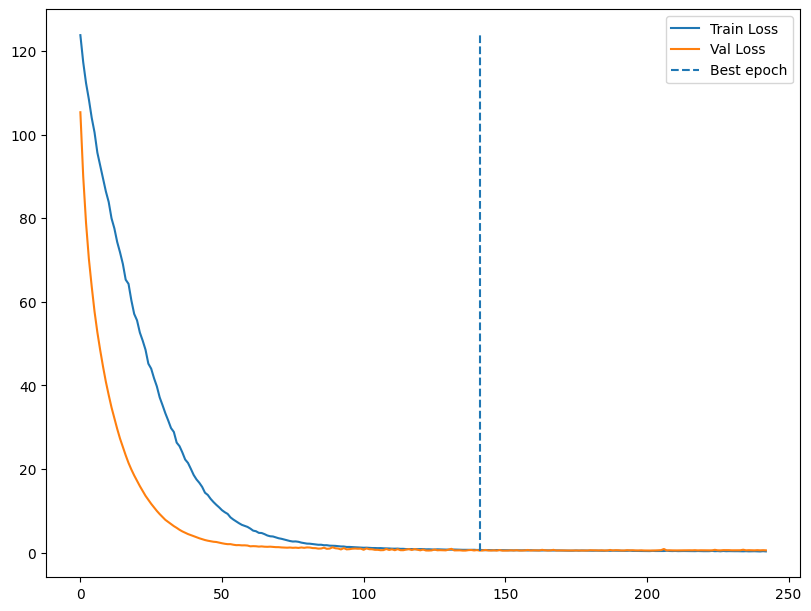

(20000, 555)
(20000,)
Train - f1=0.8113 recall=0.8866 precision=0.7478 log-loss=0.2669 opt-log-loss=0.2676
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.6431 opt-log-loss=0.5116

-- Fold # 7/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.6005 - Val: 0.5915 at epoch 147.
Restore the best model.


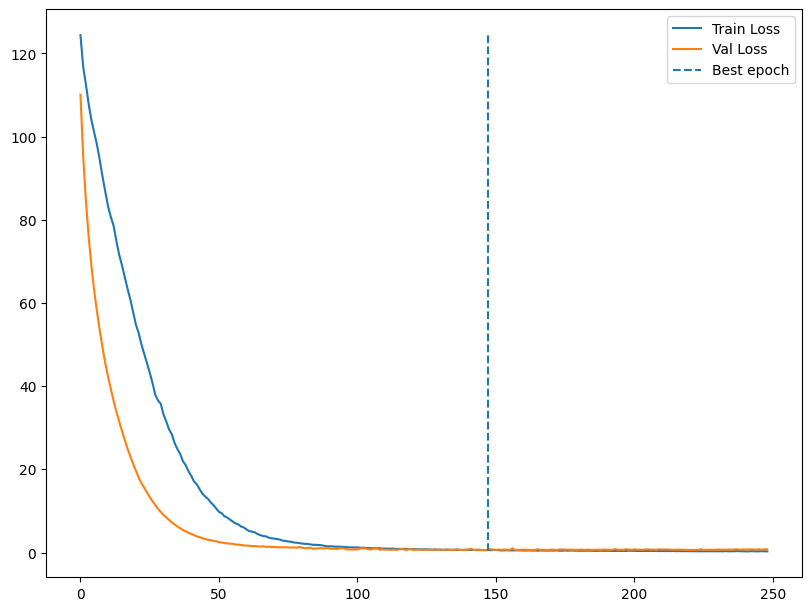

(20000, 555)
(20000,)
Train - f1=0.7963 recall=0.8866 precision=0.7227 log-loss=0.2900 opt-log-loss=0.2738
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=1.0991 opt-log-loss=0.8219

-- Fold # 8/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1775 - Val: 0.3703 at epoch 311.
Restore the best model.


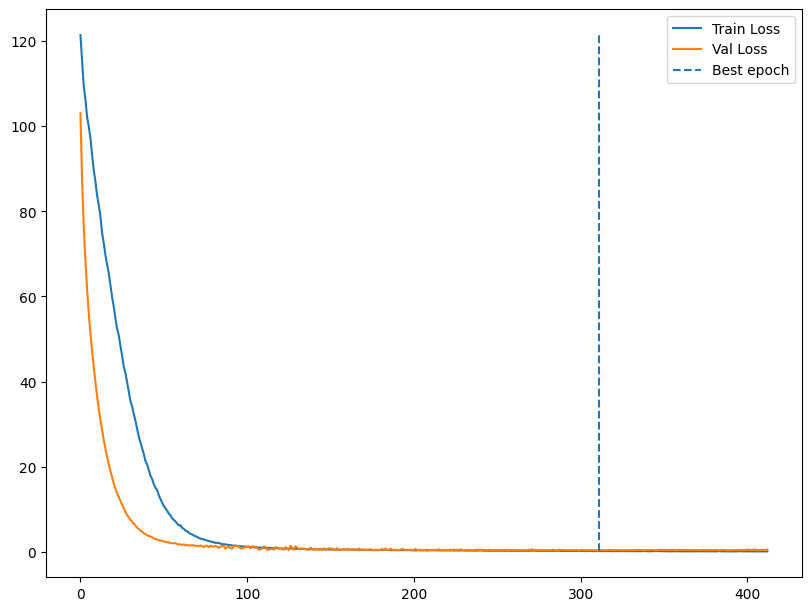

(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0201 opt-log-loss=0.0229
(20000, 61)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.4140 opt-log-loss=0.3545

-- Fold # 8/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2722 - Val: 0.2813 at epoch 257.
Restore the best model.


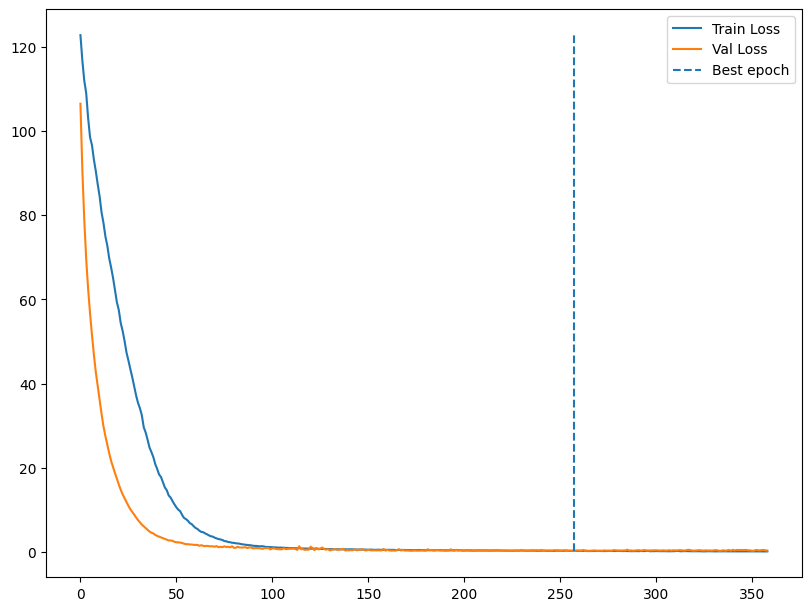

(20000, 556)
(20000,)
Train - f1=0.9600 recall=0.9897 precision=0.9320 log-loss=0.0568 opt-log-loss=0.0601
(20000, 61)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.2675 opt-log-loss=0.1937

-- Fold # 8/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4803 - Val: 0.3172 at epoch 184.
Restore the best model.


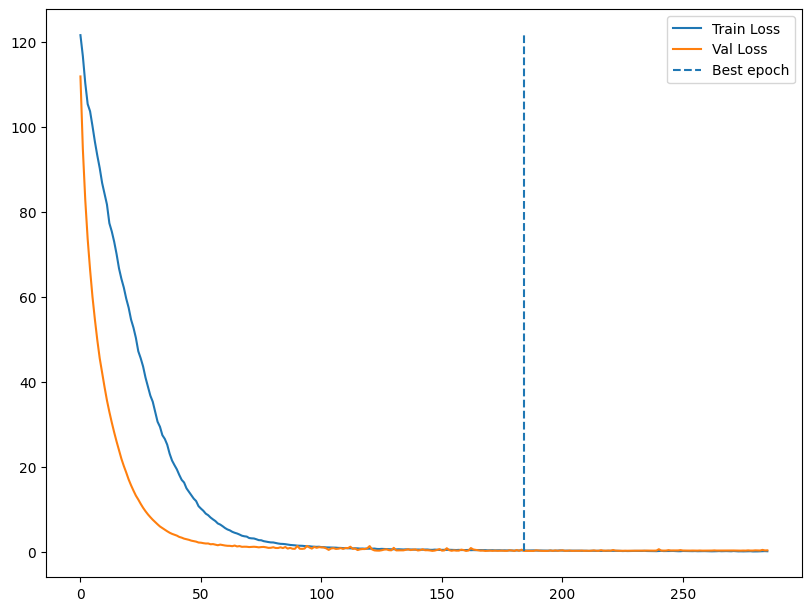

(20000, 556)
(20000,)
Train - f1=0.8856 recall=0.9175 precision=0.8558 log-loss=0.1974 opt-log-loss=0.1631
(20000, 61)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.3030 opt-log-loss=0.2678

-- Fold # 8/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3511 - Val: 0.3037 at epoch 213.
Restore the best model.


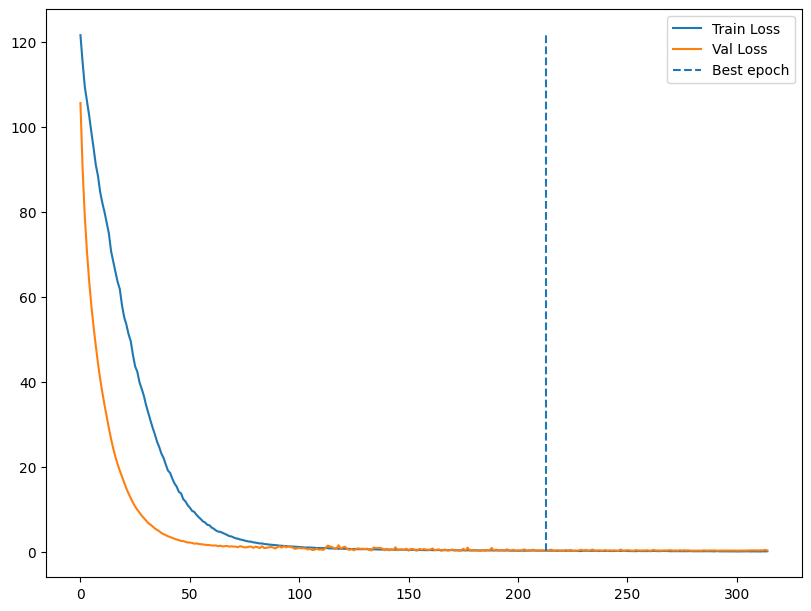

(20000, 556)
(20000,)
Train - f1=0.9447 recall=0.9691 precision=0.9216 log-loss=0.0972 opt-log-loss=0.0880
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.7273 precision=0.6154 log-loss=0.2844 opt-log-loss=0.2490

-- Fold # 8/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3888 - Val: 0.3724 at epoch 199.
Restore the best model.


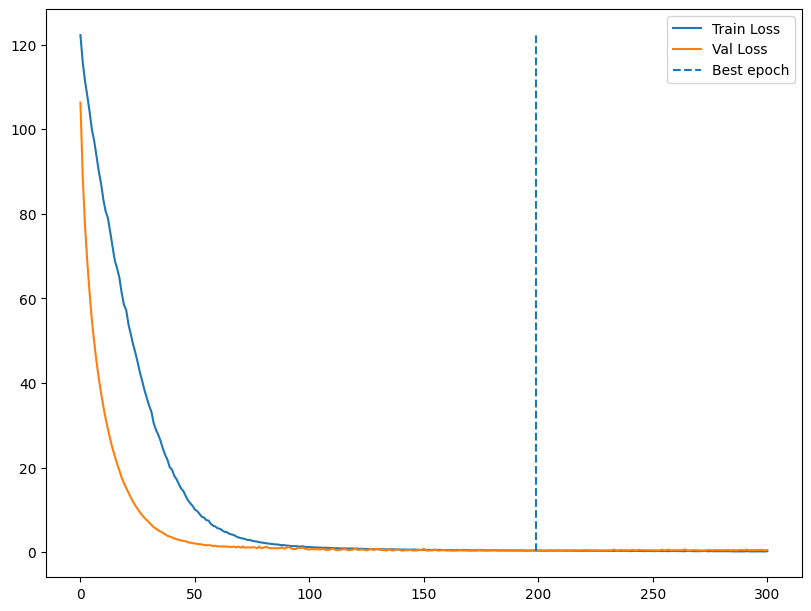

(20000, 556)
(20000,)
Train - f1=0.8986 recall=0.9588 precision=0.8455 log-loss=0.1414 opt-log-loss=0.1380
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.4086 opt-log-loss=0.3082

-- Fold # 8/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3123 - Val: 0.3329 at epoch 224.
Restore the best model.


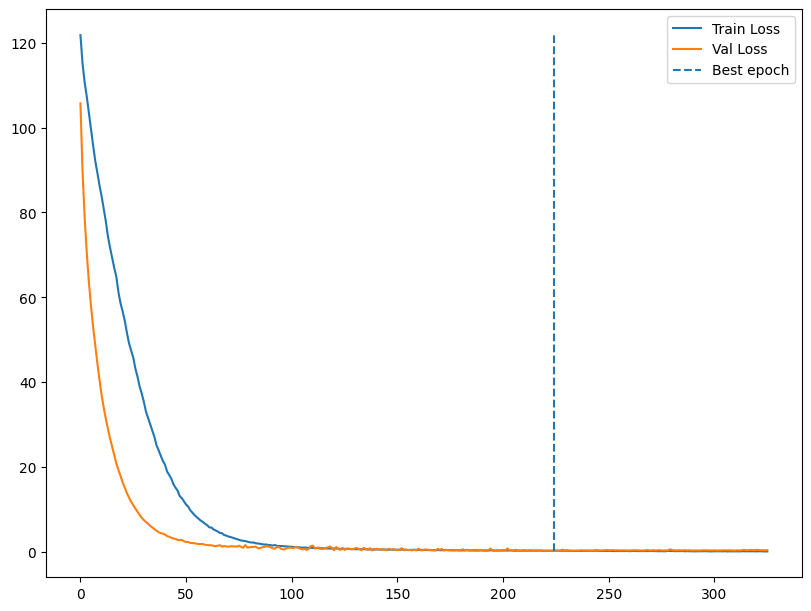

(20000, 556)
(20000,)
Train - f1=0.9412 recall=0.9072 precision=0.9778 log-loss=0.1674 opt-log-loss=0.0785
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.4340 opt-log-loss=0.2797

-- Fold # 8/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4311 - Val: 0.3289 at epoch 178.
Restore the best model.


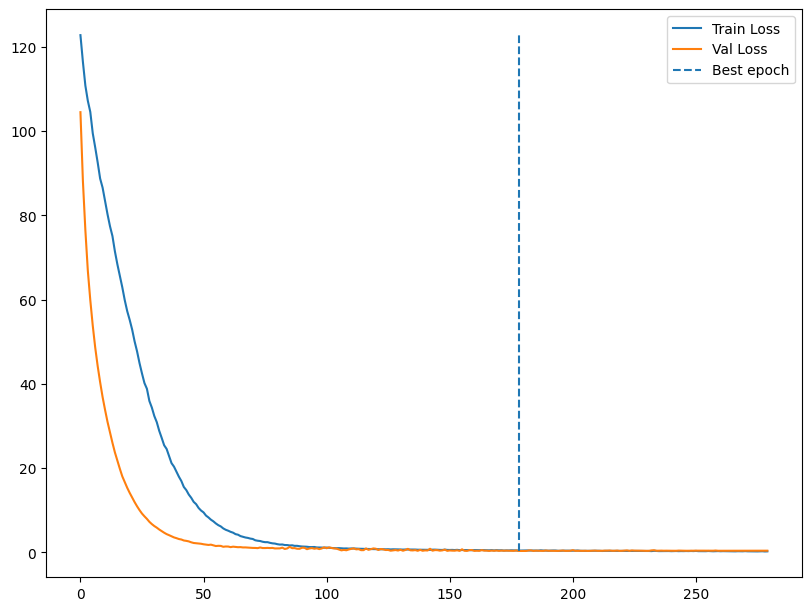

(20000, 556)
(20000,)
Train - f1=0.8599 recall=0.9175 precision=0.8091 log-loss=0.1849 opt-log-loss=0.1741
(20000, 61)
(20000,)
Test  - f1=0.7692 recall=0.9091 precision=0.6667 log-loss=0.2876 opt-log-loss=0.2527

-- Fold # 8/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4985 - Val: 0.3510 at epoch 167.
Restore the best model.


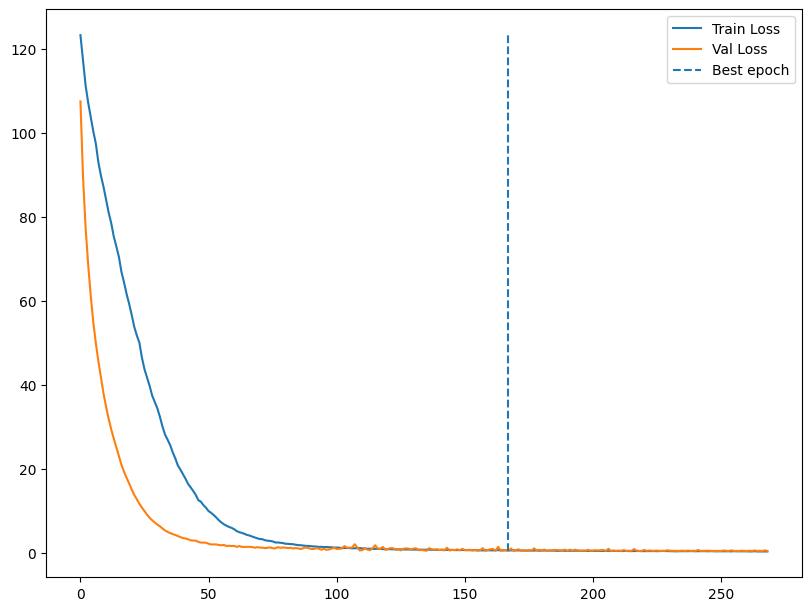

(20000, 556)
(20000,)
Train - f1=0.8377 recall=0.8247 precision=0.8511 log-loss=0.2631 opt-log-loss=0.1840
(20000, 61)
(20000,)
Test  - f1=0.6923 recall=0.8182 precision=0.6000 log-loss=0.3718 opt-log-loss=0.2997

-- Fold # 8/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3602 - Val: 0.2864 at epoch 201.
Restore the best model.


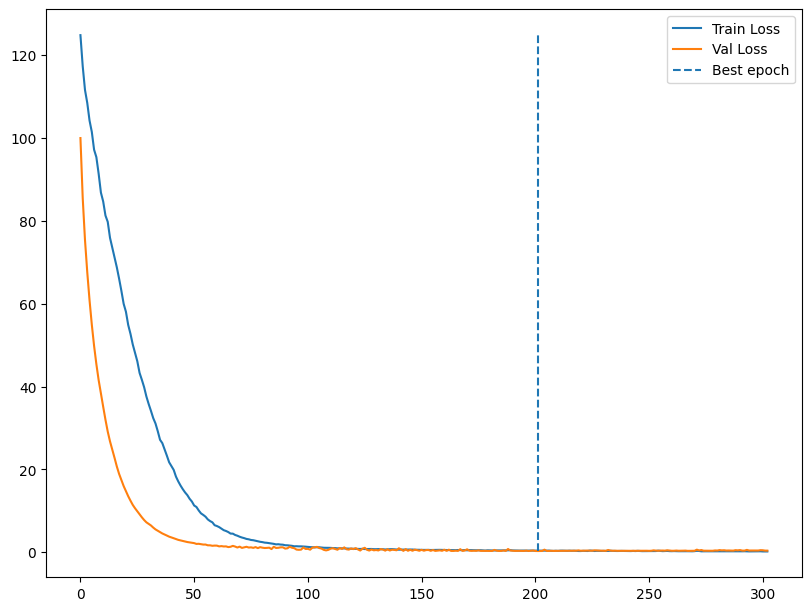

(20000, 556)
(20000,)
Train - f1=0.9347 recall=0.9588 precision=0.9118 log-loss=0.1103 opt-log-loss=0.1064
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.3125 opt-log-loss=0.2625

-- Fold # 8/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2616 - Val: 0.3503 at epoch 247.
Restore the best model.


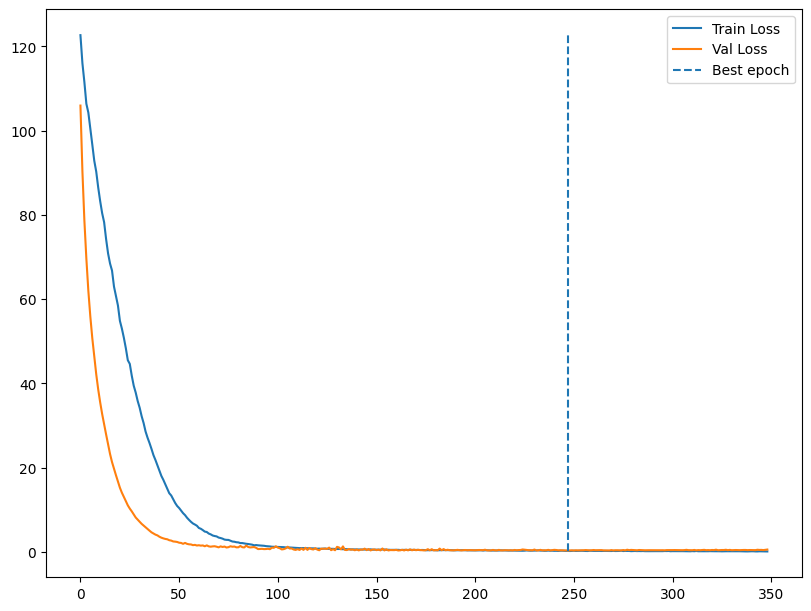

(20000, 556)
(20000,)
Train - f1=0.9691 recall=0.9691 precision=0.9691 log-loss=0.0789 opt-log-loss=0.0525
(20000, 61)
(20000,)
Test  - f1=0.7500 recall=0.8182 precision=0.6923 log-loss=0.4238 opt-log-loss=0.3172

-- Fold # 9/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1685 - Val: 0.3140 at epoch 332.
Restore the best model.


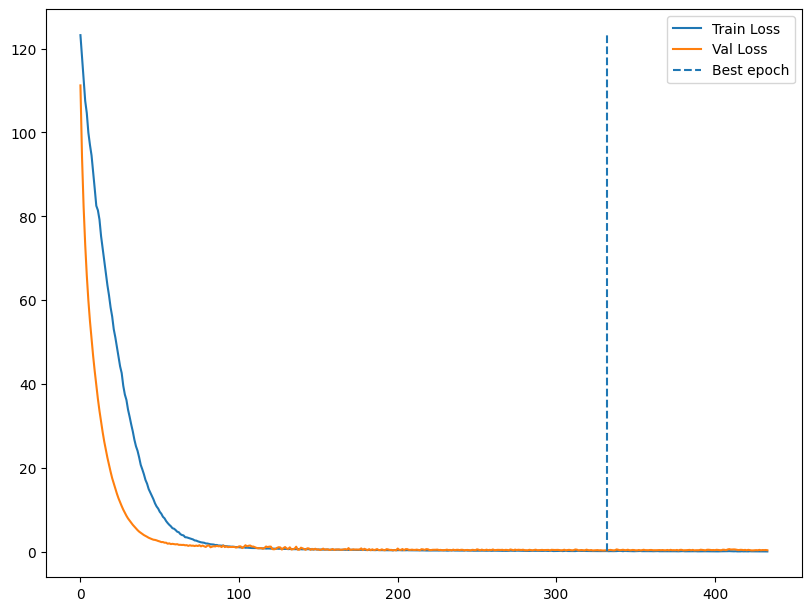

(20000, 556)
(20000,)
Train - f1=0.9949 recall=0.9898 precision=1.0000 log-loss=0.0378 opt-log-loss=0.0145
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.8000 precision=0.7273 log-loss=0.4933 opt-log-loss=0.4753

-- Fold # 9/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0141 - Val: 0.2184 at epoch 857.
Restore the best model.


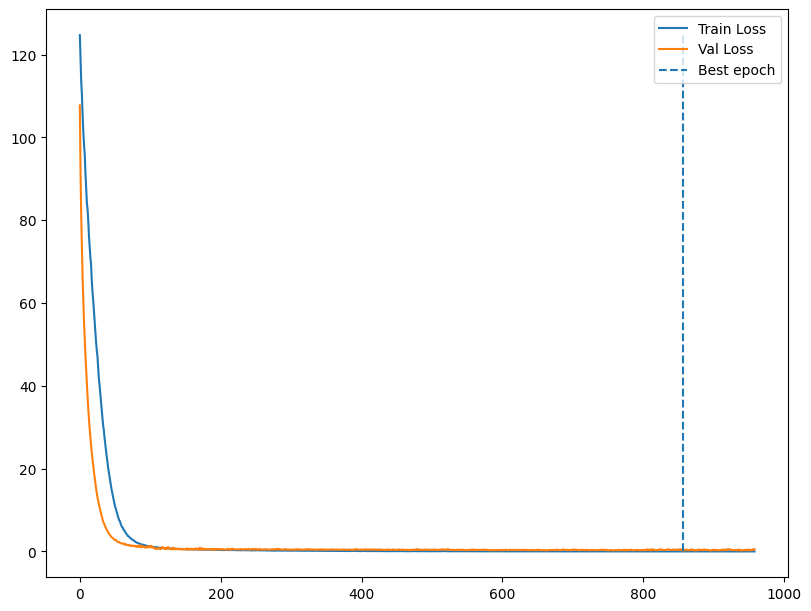

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0038 opt-log-loss=0.0027
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.5526 opt-log-loss=0.4123

-- Fold # 9/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3971 - Val: 0.3640 at epoch 180.
Restore the best model.


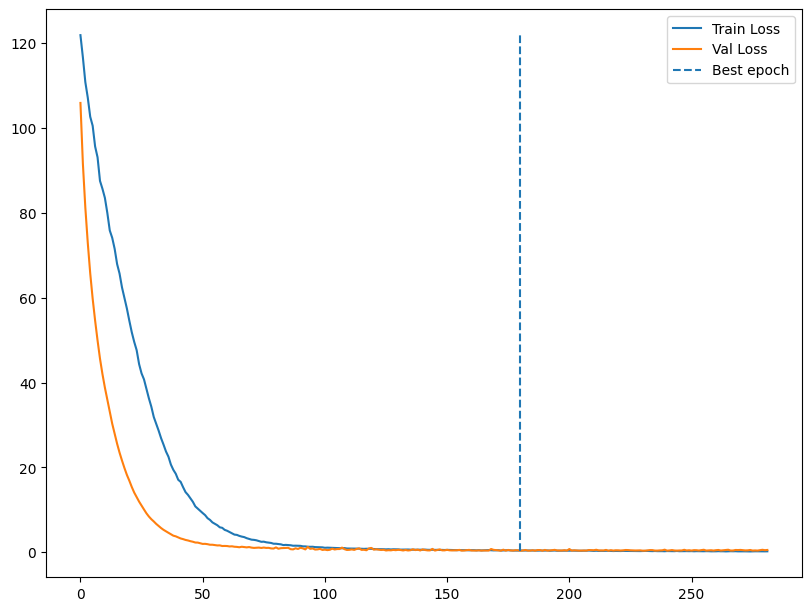

(20000, 556)
(20000,)
Train - f1=0.7602 recall=0.6633 precision=0.8904 log-loss=0.3408 opt-log-loss=0.1561
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.8000 precision=0.7273 log-loss=0.6293 opt-log-loss=0.4749

-- Fold # 9/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1548 - Val: 0.3478 at epoch 338.
Restore the best model.


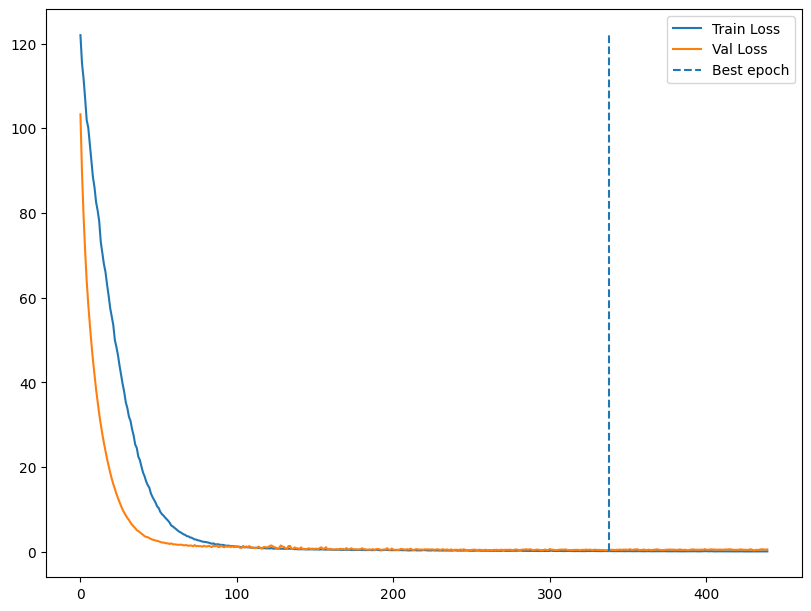

(20000, 556)
(20000,)
Train - f1=0.9845 recall=0.9694 precision=1.0000 log-loss=0.0687 opt-log-loss=0.0191
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.7113 opt-log-loss=0.6128

-- Fold # 9/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0130 - Val: 0.2064 at epoch 758.
Restore the best model.


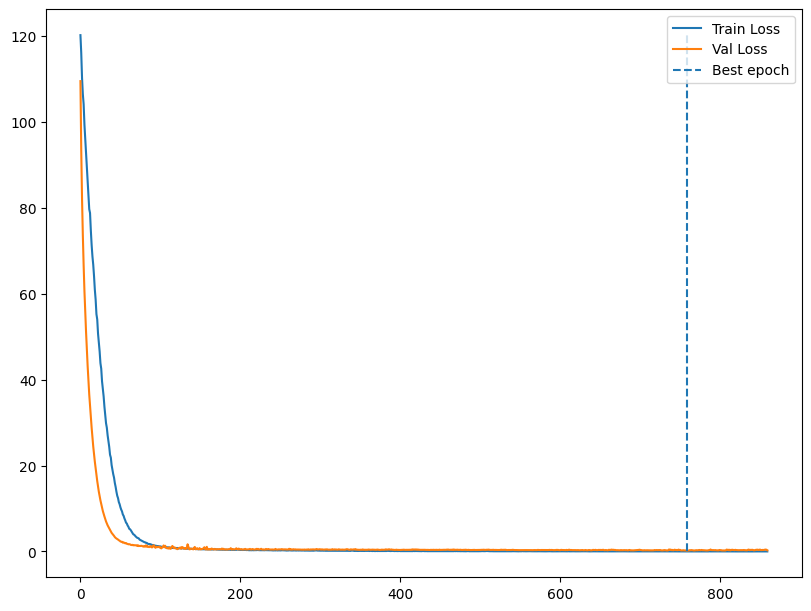

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0032 opt-log-loss=0.0028
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.4886 opt-log-loss=0.3792

-- Fold # 9/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3358 - Val: 0.4109 at epoch 203.
Restore the best model.


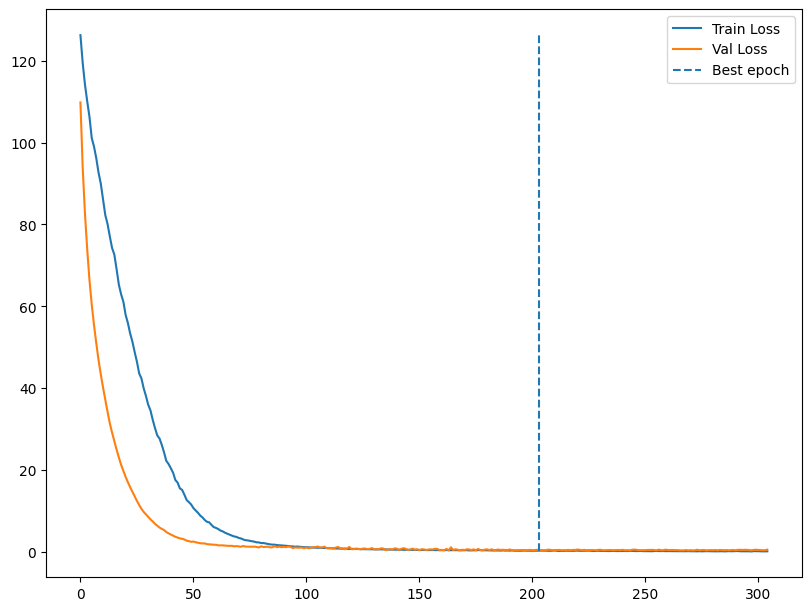

(20000, 556)
(20000,)
Train - f1=0.7904 recall=0.6735 precision=0.9565 log-loss=0.3148 opt-log-loss=0.1071
(20000, 61)
(20000,)
Test  - f1=0.7059 recall=0.6000 precision=0.8571 log-loss=0.8139 opt-log-loss=0.5971

-- Fold # 9/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4712 - Val: 0.3746 at epoch 164.
Restore the best model.


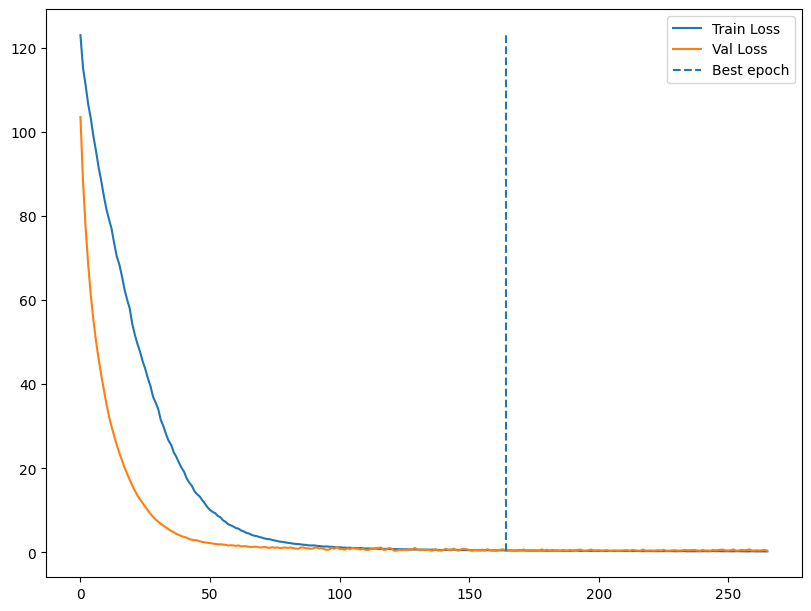

(20000, 556)
(20000,)
Train - f1=0.7861 recall=0.6939 precision=0.9067 log-loss=0.3311 opt-log-loss=0.1670
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.6004 opt-log-loss=0.4885

-- Fold # 9/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.6176 - Val: 0.3770 at epoch 136.
Restore the best model.


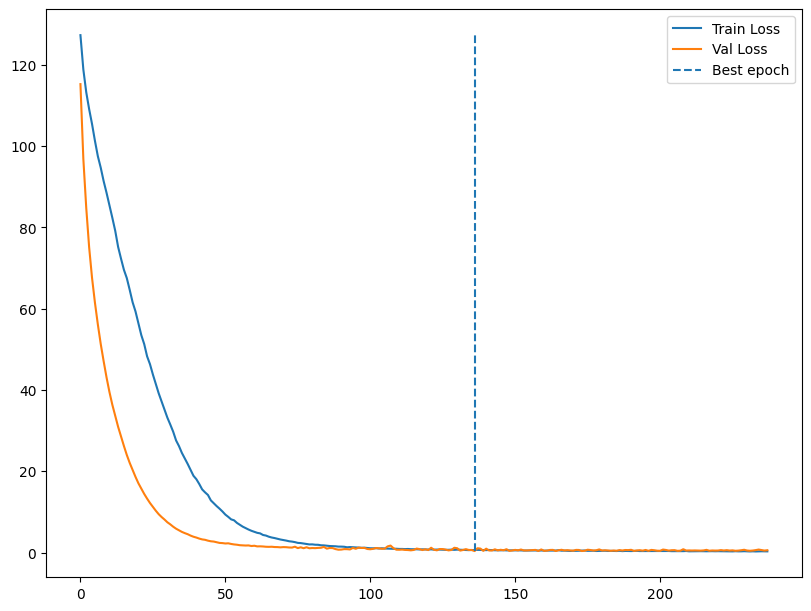

(20000, 556)
(20000,)
Train - f1=0.7152 recall=0.6020 precision=0.8806 log-loss=0.4609 opt-log-loss=0.2399
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.6300 opt-log-loss=0.5084

-- Fold # 9/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0105 - Val: 0.1951 at epoch 861.
Restore the best model.


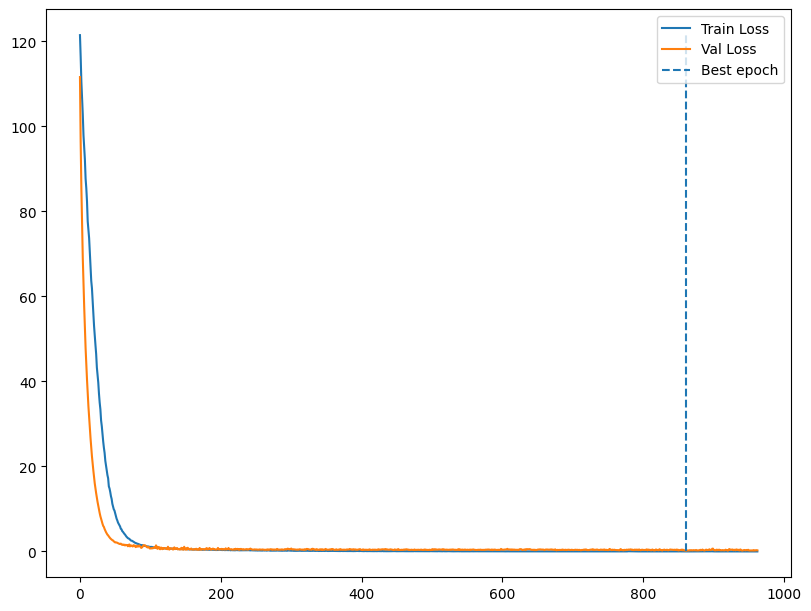

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0026 opt-log-loss=0.0029
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.4950 opt-log-loss=0.3569

-- Fold # 9/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3877 - Val: 0.3811 at epoch 212.
Restore the best model.


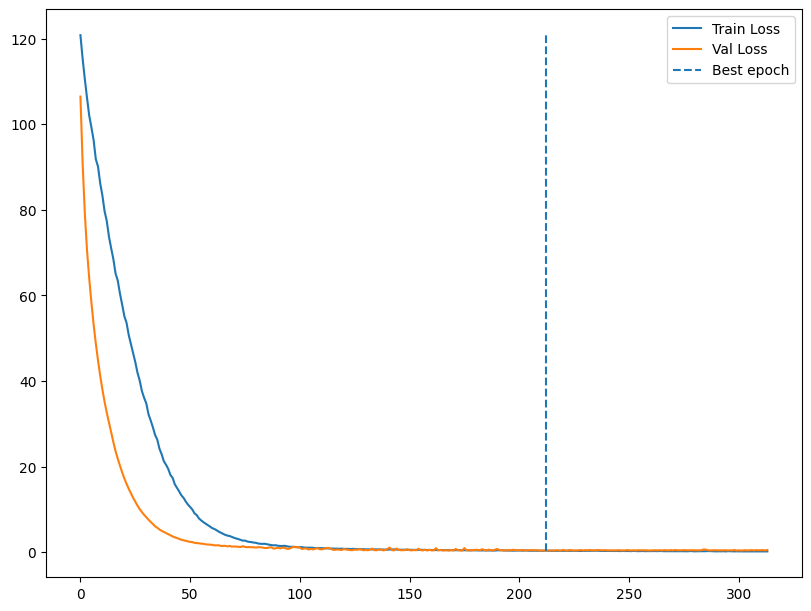

(20000, 556)
(20000,)
Train - f1=0.9184 recall=0.9184 precision=0.9184 log-loss=0.1785 opt-log-loss=0.1063
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.8000 precision=0.7273 log-loss=0.6022 opt-log-loss=0.4736

-- Fold # 10/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1870 - Val: 0.2819 at epoch 333.
Restore the best model.


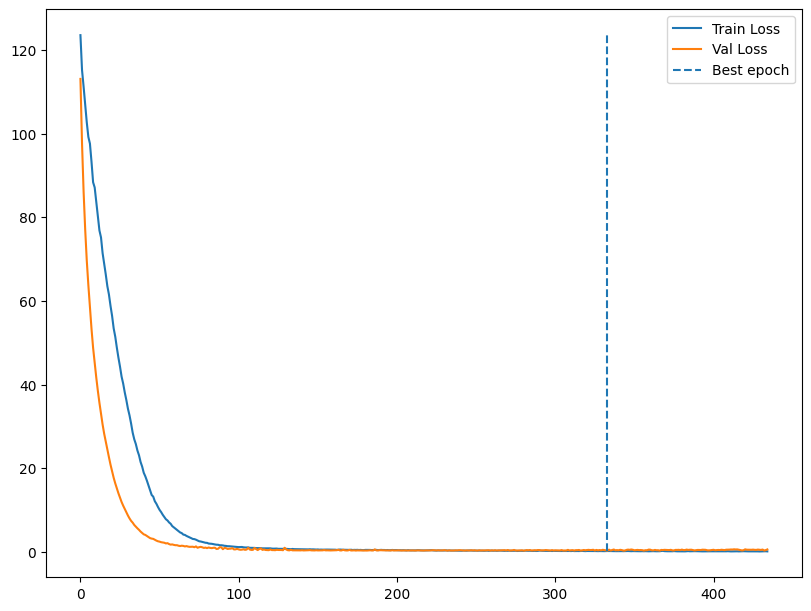

(20000, 556)
(20000,)
Train - f1=0.9849 recall=1.0000 precision=0.9703 log-loss=0.0193 opt-log-loss=0.0368
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.3337 opt-log-loss=0.2419

-- Fold # 10/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3358 - Val: 0.2335 at epoch 207.
Restore the best model.


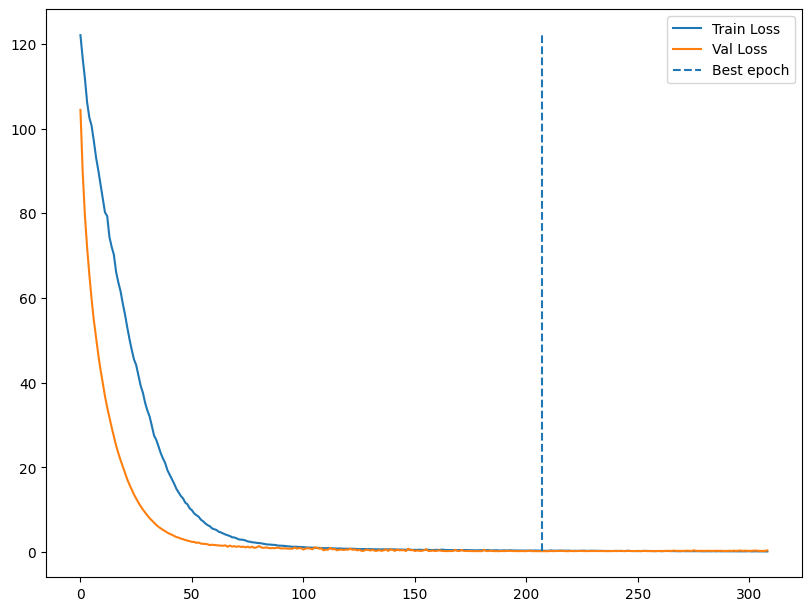

(20000, 556)
(20000,)
Train - f1=0.8649 recall=0.9796 precision=0.7742 log-loss=0.1259 opt-log-loss=0.1542
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2049 opt-log-loss=0.1745

-- Fold # 10/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2707 - Val: 0.2734 at epoch 282.
Restore the best model.


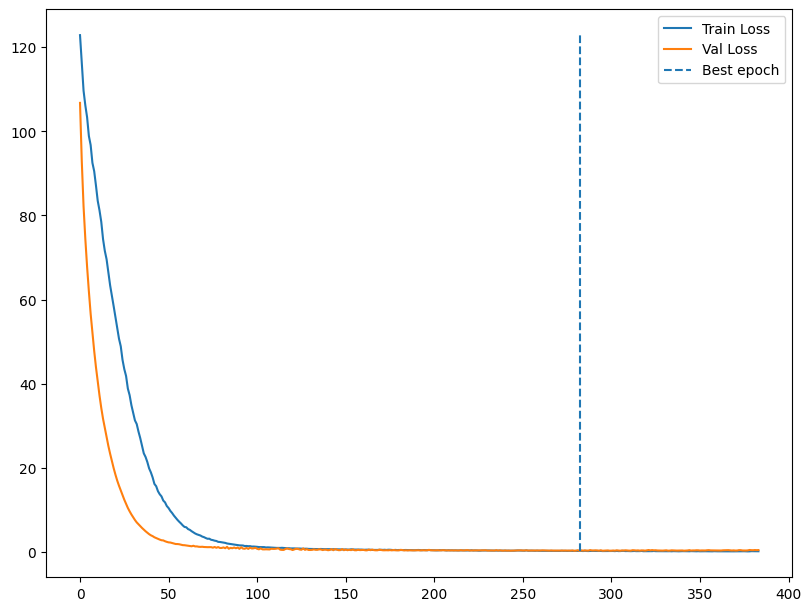

(20000, 556)
(20000,)
Train - f1=0.9423 recall=1.0000 precision=0.8909 log-loss=0.0418 opt-log-loss=0.0737
(20000, 61)
(20000,)
Test  - f1=0.7368 recall=0.7000 precision=0.7778 log-loss=0.3905 opt-log-loss=0.2777

-- Fold # 10/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0926 - Val: 0.2759 at epoch 472.
Restore the best model.


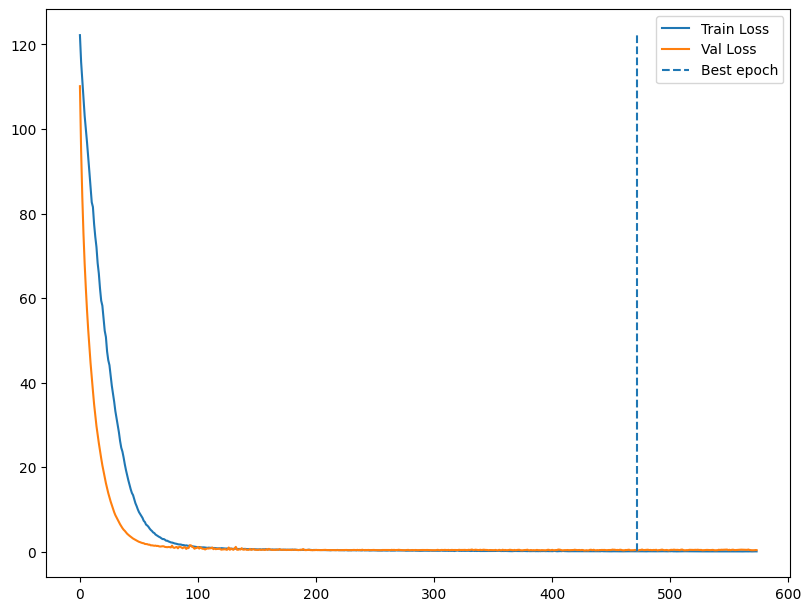

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0054 opt-log-loss=0.0068
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.4603 opt-log-loss=0.3163

-- Fold # 10/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1799 - Val: 0.2889 at epoch 327.
Restore the best model.


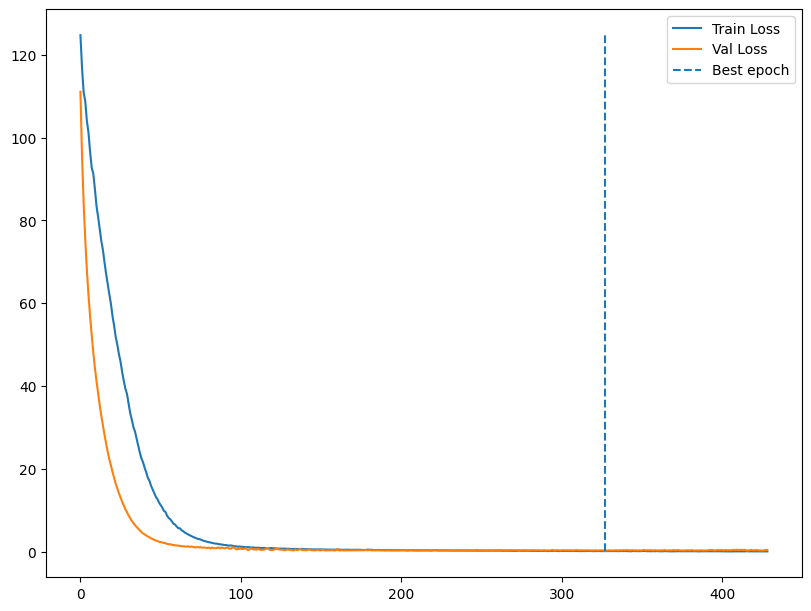

(20000, 556)
(20000,)
Train - f1=0.9849 recall=1.0000 precision=0.9703 log-loss=0.0164 opt-log-loss=0.0301
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.3924 opt-log-loss=0.2751

-- Fold # 10/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2368 - Val: 0.3090 at epoch 280.
Restore the best model.


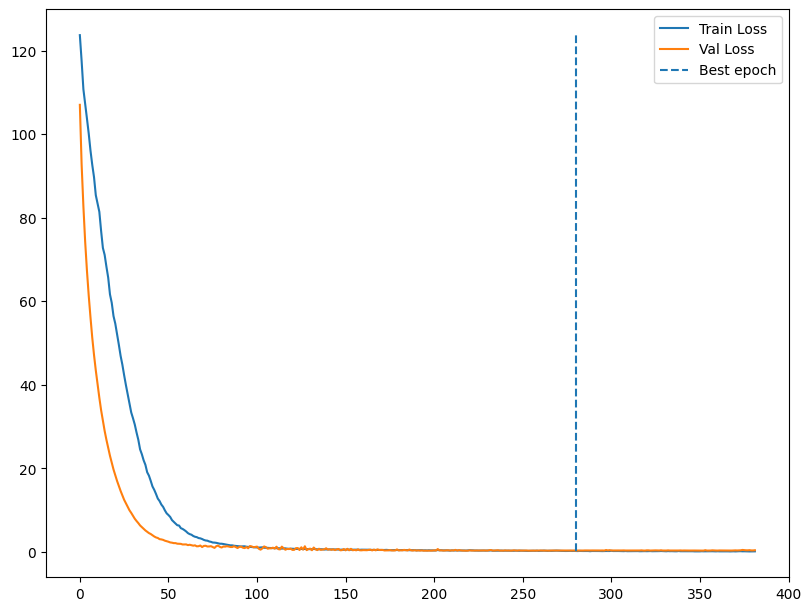

(20000, 556)
(20000,)
Train - f1=0.9694 recall=0.9694 precision=0.9694 log-loss=0.0530 opt-log-loss=0.0428
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.5302 opt-log-loss=0.3642

-- Fold # 10/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1111 - Val: 0.3314 at epoch 370.
Restore the best model.


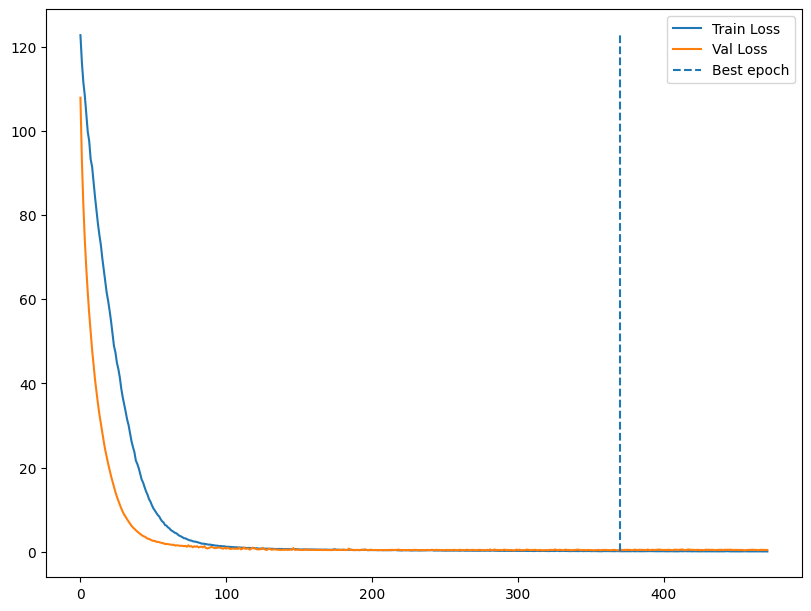

(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0132 opt-log-loss=0.0119
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.5864 opt-log-loss=0.4111

-- Fold # 10/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2533 - Val: 0.3623 at epoch 273.
Restore the best model.


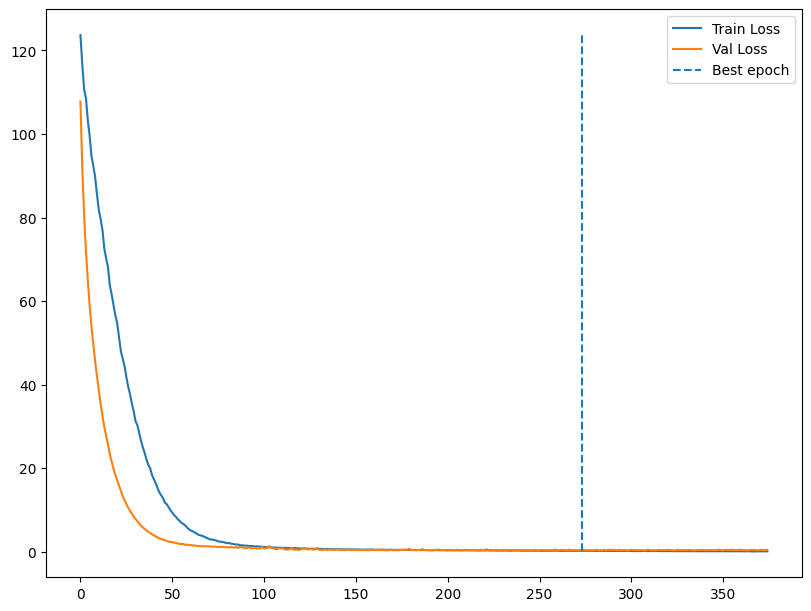

(20000, 556)
(20000,)
Train - f1=0.9463 recall=0.9898 precision=0.9065 log-loss=0.0453 opt-log-loss=0.0652
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.7000 precision=0.7000 log-loss=0.5403 opt-log-loss=0.4043

-- Fold # 10/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4087 - Val: 0.3344 at epoch 207.
Restore the best model.


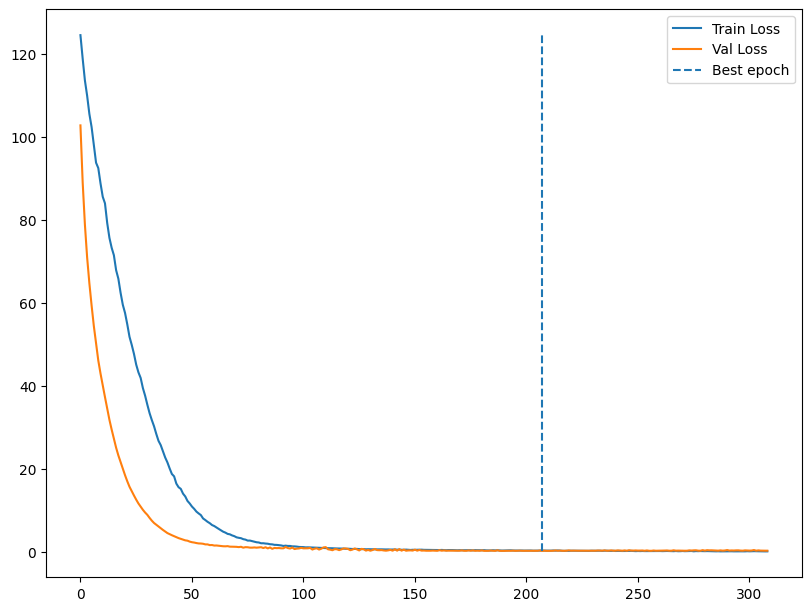

(20000, 556)
(20000,)
Train - f1=0.8479 recall=0.9388 precision=0.7731 log-loss=0.1547 opt-log-loss=0.1625
(20000, 61)
(20000,)
Test  - f1=0.7778 recall=0.7000 precision=0.8750 log-loss=0.5735 opt-log-loss=0.4218

-- Fold # 10/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1679 - Val: 0.3077 at epoch 317.
Restore the best model.


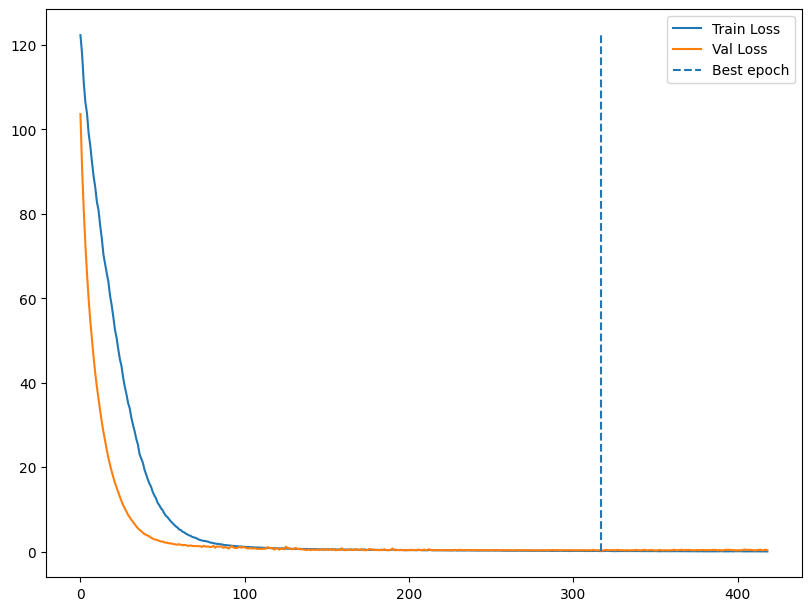

(20000, 556)
(20000,)
Train - f1=0.9751 recall=1.0000 precision=0.9515 log-loss=0.0240 opt-log-loss=0.0463
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.8000 precision=0.7273 log-loss=0.3913 opt-log-loss=0.3071


In [18]:
def balanced_log_loss(y_true, pred_prob):
    nb_class_0 = np.sum(1 - y_true)
    nb_class_1 = np.sum(y_true)

    prob_0 = np.clip(1. - pred_prob, 1e-10, 1. - 1e-10)
    prob_1 = np.clip(pred_prob, 1e-10, 1. - 1e-10)
    return (-np.sum((1 - y_true) * np.log(prob_0)) / nb_class_0
            - np.sum(y_true * np.log(prob_1)) / nb_class_1) / 2.


def calculate_optimal_prob_prediction(y_preds):
    """
    Calculate the best probability prediction based on the formula
    (in experiment 04_logistics_bayesian_v4*).

    y_preds: numpy array of shape (nb_draws, nb_data_points).
    """
    assert y_preds.ndim == 2, "Only accept 2d numpy array as input."
    _, nb_data = y_preds.shape
    print(y_preds.shape)

    # Calculate number of classes for each draw.
    nb_class_0 = np.sum(1 - y_preds, axis=1)
    print(nb_class_0.shape)
    nb_class_1 = np.sum(y_preds, axis=1)

    best_probs = []
    eps = 1e-15
    for j in range(nb_data):
        cj = np.sum(y_preds[:, j] / (nb_class_1 + eps))
        cj_1 = np.sum((1 - y_preds[:, j]) / (nb_class_0 + eps))

        prob = cj / (cj + cj_1)
        best_probs.append(prob)

    return np.asarray(best_probs)


def estimate_optimal_prob_pred(y_prob, nb_samples: int = 20000):
    ys = bernoulli.rvs(y_prob[:, None], size=(y_prob.shape[0], nb_samples))
    return calculate_optimal_prob_prediction(ys.T)


def f1_recall_precision(y_true, y_pred):
    return tuple(f(y_true, y_pred)
                 for f in [f1_score, recall_score, precision_score])


def plot_train_history(history: dict, epochs: int):
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')

    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = list(range(len(train_loss)))
    ax.plot(epochs, train_loss, label='Train Loss')
    ax.plot(epochs, val_loss, label='Val Loss')
    ax.vlines(
        history['best_epoch'],
        ymin=min(min(train_loss), min(val_loss)),
        ymax=max(max(train_loss), max(val_loss)),
        label='Best epoch',
        linestyles='dashed')
    ax.legend()

    return fig


def train_and_evaluate(*,
                       Xtr, gtr, ytr,
                       Xte, gte, yte,
                       epochs: int = 100,
                       device: str = 'cpu',
                       lr: float = 1e-3,
                       train_noise: float = 0.0,
                       early_stopping_patience: int = 100,
                       correlation_threshold: float = 0.3,
                       weight_decay: float = 1e-2,
                       regularization_weight: float = 1.0):
    # First, we will normalize the data.
    Xtr = pd.DataFrame(
        preprocessing.fit_transform(Xtr, ytr),
        columns=Xtr.columns)
    Xte = pd.DataFrame(
        preprocessing.transform(Xte),
        columns=Xte.columns)

    # Next, we'll filter out correlated features.
    Xtr = filter_in_uncorrelated_features(
        Xtr, correlation_threshold=correlation_threshold)
    Xte = Xte[Xtr.columns]

    # Store original training dataset.
    Xtr_orig = Xtr.copy()
    Xtr_orig['ej'] = gtr
    ytr_orig = ytr.copy()
    print(f'Before sampling, has {len(ytr_orig)} sammples,\n'
          f'in which there are {ytr_orig.sum()} positive samples.')

    # Next, we'll perform sampling.
    Xtr['ej'] = gtr
    Xte['ej'] = gte

    Xtr, ytr = sampling(Xtr, ytr)
    print(f'After sampling, has {len(ytr)} sammples,\n'
          f'in which there are {ytr.sum()} positive samples.')

    # Then, we use tree-based model to select important features.
    # Xtr = select_important_features(
    #     Xtr, ytr,
    #     n_estimators=1000,
    #     important_thresholds='5*median')
    # Xte = Xte[Xtr.columns]
    nb_features = len(Xtr.columns)
    print('Number of important features: ', nb_features)

    # Training neural network model.
    # print(Xtr.values, ytr[:, None])
    X_train_ds = TensorDataset(
        torch.tensor(Xtr.values, dtype=torch.float32),
        torch.tensor(ytr[:, None], dtype=torch.float32))
    X_val_ds = TensorDataset(
        torch.tensor(Xte.values, dtype=torch.float32),
        torch.tensor(yte[:, None], dtype=torch.float32))

    Xtr_dataloader = DataLoader(X_train_ds, batch_size=64, shuffle=True)
    Xva_dataloader = DataLoader(X_val_ds, batch_size=64)

    model, history = train(NNClassifier(nb_features),
                           train_ds=Xtr_dataloader,
                           val_ds=Xva_dataloader,
                           epochs=epochs,
                           early_stopping_patience=early_stopping_patience,
                           device=device,
                           lr=lr,
                           weight_decay=weight_decay,
                           regularization_weight=regularization_weight,
                           train_noise=train_noise)

    # Plot training history.
    fig = plot_train_history(history, epochs=epochs)
    plt.show()
    plt.close(fig)

    # Evaluate the model.
    ytr_prob = (model(
        torch.tensor(Xtr_orig.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    ytr_opt_prob = estimate_optimal_prob_pred(ytr_prob)
    ytr_pred = np.where(ytr_prob > 0.5, 1., 0.)
    (f1_train,
     recall_train,
     precision_train) = f1_recall_precision(ytr_orig, ytr_pred)
    log_loss_train = balanced_log_loss(ytr_orig, ytr_prob)
    opt_log_loss_train = balanced_log_loss(ytr_orig, ytr_opt_prob)
    print(f'Train - f1={f1_train:.4f} recall={recall_train:.4f} '
          f'precision={precision_train:.4f} log-loss={log_loss_train:.4f} '
          f'opt-log-loss={opt_log_loss_train:.4f}')

    yte_prob = (model(
        torch.tensor(Xte.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    yte_opt_prob = estimate_optimal_prob_pred(yte_prob)
    yte_pred = np.where(yte_prob > 0.5, 1., 0.)
    (f1_test,
     recall_test,
     precision_test) = f1_recall_precision(yte, yte_pred)
    log_loss_test = balanced_log_loss(yte, yte_prob)
    opt_log_loss_test = balanced_log_loss(yte, yte_opt_prob)
    print(f'Test  - f1={f1_test:.4f} recall={recall_test:.4f} '
          f'precision={precision_test:.4f} log-loss={log_loss_test:.4f} '
          f'opt-log-loss={opt_log_loss_test:.4f}')

    return dict(
        f1_train=f1_train,
        f1_test=f1_test,
        log_loss_train=log_loss_train,
        opt_log_loss_train=opt_log_loss_train,
        log_loss_test=log_loss_test,
        opt_log_loss_test=opt_log_loss_test,
    )


def cross_validations(*, X, grp, y,
                      n_folds: int = 10,
                      repeats_per_fold: int = 1,
                      **kwargs):
    results = []

    kfolds = StratifiedKFold(n_splits=n_folds)
    for fold, (train_idx, test_idx) in enumerate(kfolds.split(X, y)):
        for repeat in range(repeats_per_fold):
            print(f'\n-- Fold # {fold + 1}/{n_folds} - '
                  f'Repeat #{repeat + 1}/{repeats_per_fold}:')

            Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
            gtr, gte = grp[train_idx], grp[test_idx]
            ytr, yte = y[train_idx], y[test_idx]

            result = train_and_evaluate(
                Xtr=Xtr, gtr=gtr, ytr=ytr,
                Xte=Xte, gte=gte, yte=yte,
                **kwargs)

            result['fold'] = fold + 1
            result['repeat'] = repeat + 1
            results.append(result)

    return pd.DataFrame(results)


cv_results = cross_validations(
    X=Xtrain_df,
    grp=ej.cat.codes.values,
    y=y,
    n_folds=10,
    repeats_per_fold=10,
    epochs=2000,
    correlation_threshold=0.3,
    lr=1e-4,
    early_stopping_patience=100,
    weight_decay=1e-2,
    regularization_weight=1.0,
    train_noise=0.1)

In [19]:
cv_results

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0   0.979592  0.833333        0.044683            0.045319       0.212672   
1   0.917073  0.800000        0.107455            0.114013       0.298620   
2   0.932642  0.736842        0.126766            0.098569       0.400623   
3   1.000000  0.700000        0.006386            0.004864       0.404717   
4   1.000000  0.736842        0.007535            0.006576       0.378407   
..       ...       ...             ...                 ...            ...   
95  0.969388  0.800000        0.052979            0.042785       0.530198   
96  1.000000  0.800000        0.013180            0.011913       0.586408   
97  0.946341  0.700000        0.045320            0.065225       0.540333   
98  0.847926  0.777778        0.154659            0.162462       0.573514   
99  0.975124  0.761905        0.024033            0.046275       0.391316   

    opt_log_loss_test  fold  repeat  
0            0.174743     1       1  
1            0.247057     1       2  
2            0.265008     1       3  
3            0.241855     1       4  
4            0.216988     1       5  
..                ...   ...     ...  
95           0.364163    10       6  
96           0.411113    10       7  
97           0.404274    10       8  
98           0.421758    10       9  
99           0.307135    10      10  

[100 rows x 8 columns]

In [20]:
def get_optimal_cv_results_each_fold(results: pd.DataFrame,
                                     by: str,
                                     method: Literal['max', 'min'] = 'max'):
    folds = results.groupby('fold')

    optimal_results = []
    for fold, fold_results in folds:
        best_idx = (fold_results[by].argmax()
                    if method == 'max'
                    else fold_results[by].argmin())
        optimal_result = fold_results.iloc[best_idx].to_dict()
        optimal_results.append(optimal_result)

    return pd.DataFrame(optimal_results)

## Results
### Optimal F1 Test

In [21]:
# Optimal results per fold by f1_test.
cv_results_optimal_f1_test = get_optimal_cv_results_each_fold(
    cv_results, 'f1_test', 'max')
cv_results_optimal_f1_test

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.984615  0.869565        0.036409            0.034585       0.164809   
1  0.845455  0.869565        0.143682            0.168722       0.229476   
2  0.994872  0.800000        0.012984            0.013254       0.404692   
3  0.886700  0.818182        0.180041            0.135382       0.352989   
4  0.903846  0.909091        0.065620            0.093970       0.142347   
5  0.994872  0.695652        0.008748            0.018024       0.625604   
6  0.886792  0.608696        0.171491            0.180110       0.660006   
7  0.994872  0.818182        0.020087            0.022876       0.413971   
8  1.000000  0.888889        0.003797            0.002729       0.552638   
9  0.864865  0.900000        0.125934            0.154235       0.204935   

   opt_log_loss_test  fold  repeat  
0           0.124154   1.0     7.0  
1           0.201815   2.0     5.0  
2           0.289055   3.0     3.0  
3           0.272789   4.0     1.0  
4           0.112259   5.0     1.0  
5           0.537741   6.0     5.0  
6           0.556368   7.0     8.0  
7           0.354542   8.0     1.0  
8           0.412311   9.0     2.0  
9           0.174545  10.0     2.0

In [22]:
cv_results_optimal_f1_test.describe()

f1_train    f1_test  log_loss_train  opt_log_loss_train  \
count  10.000000  10.000000       10.000000           10.000000   
mean    0.935689   0.817782        0.076879            0.082389   
std     0.063246   0.096877        0.071117            0.071649   
min     0.845455   0.608696        0.003797            0.002729   
25%     0.886723   0.804545        0.014760            0.019237   
50%     0.944231   0.843874        0.051015            0.064277   
75%     0.994872   0.884058        0.139245            0.149522   
max     1.000000   0.909091        0.180041            0.180110   

       log_loss_test  opt_log_loss_test      fold     repeat  
count      10.000000          10.000000  10.00000  10.000000  
mean        0.375147           0.303558   5.50000   3.500000  
std         0.190578           0.159901   3.02765   2.592725  
min         0.142347           0.112259   1.00000   1.000000  
25%         0.211070           0.181363   3.25000   1.250000  
50%         0.378840           0.280922   5.50000   2.500000  
75%         0.517972           0.397869   7.75000   5.000000  
max         0.660006           0.556368  10.00000   8.000000

### Optimal `opt_log_loss_test`

In [23]:
cv_results_optimal_log_loss_test = get_optimal_cv_results_each_fold(
    cv_results, 'opt_log_loss_test', 'min')
cv_results_optimal_log_loss_test

f1_train   f1_test  log_loss_train  opt_log_loss_train  log_loss_test  \
0  0.984615  0.869565        0.036409            0.034585       0.164809   
1  0.812227  0.800000        0.167817            0.210864       0.206871   
2  0.930693  0.727273        0.145697            0.124202       0.275018   
3  0.944162  0.782609        0.135202            0.101109       0.212673   
4  0.881818  0.909091        0.071561            0.119036       0.119871   
5  0.830769  0.640000        0.281687            0.211832       0.432076   
6  0.760000  0.500000        0.327623            0.283753       0.647153   
7  0.960000  0.818182        0.056786            0.060060       0.267463   
8  1.000000  0.888889        0.002641            0.002857       0.495025   
9  0.864865  0.900000        0.125934            0.154235       0.204935   

   opt_log_loss_test  fold  repeat  
0           0.124154   1.0     7.0  
1           0.195408   2.0    10.0  
2           0.207893   3.0     1.0  
3           0.159805   4.0     9.0  
4           0.109549   5.0     2.0  
5           0.338735   6.0     3.0  
6           0.488022   7.0     2.0  
7           0.193724   8.0     2.0  
8           0.356943   9.0     9.0  
9           0.174545  10.0     2.0

In [24]:
cv_results_optimal_log_loss_test.describe()

f1_train    f1_test  log_loss_train  opt_log_loss_train  \
count  10.000000  10.000000       10.000000           10.000000   
mean    0.896915   0.783561        0.135136            0.130253   
std     0.079735   0.130580        0.103963            0.087313   
min     0.760000   0.500000        0.002641            0.002857   
25%     0.839293   0.741107        0.060480            0.070322   
50%     0.906256   0.809091        0.130568            0.121619   
75%     0.956041   0.884058        0.162287            0.196707   
max     1.000000   0.909091        0.327623            0.283753   

       log_loss_test  opt_log_loss_test      fold     repeat  
count      10.000000          10.000000  10.00000  10.000000  
mean        0.302589           0.234878   5.50000   4.700000  
std         0.167885           0.120642   3.02765   3.591657  
min         0.119871           0.109549   1.00000   1.000000  
25%         0.205419           0.163490   3.25000   2.000000  
50%         0.240068           0.194566   5.50000   2.500000  
75%         0.392812           0.306024   7.75000   8.500000  
max         0.647153           0.488022  10.00000  10.000000

### Discussions

From the results above,
we see the common trend of the model is that:

* Overfit is still there, but it is not a common pattern in all folds;
* Seems that underfit is more common;
* And the results (the log loss) is better compared to the previous experiment (in both `f1_test` and `opt_log_loss_test`).

# Results Overview

---
* Architecture: 1024 (ReLu, Dropout, LayerNorm) -> 512 (ReLu, Dropout, LayerNorm) -> 64 (LayerNorm) -> 1
* Correlation Threshold: 0.3
* LR: 1-4
* Weight Decay: 1e-2
* Regularization weight: 1.0
* Train noise: 0.0